In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.spatial import distance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
import warnings

# Data behandling

## Load data

In [116]:
data = pd.read_csv('case1Data.txt', sep=',', skipinitialspace=True)
y_mean = data['y'].mean()
y_std = data['y'].std()
data_cat = data[['C_ 1', 'C_ 2', 'C_ 3', 'C_ 4', 'C_ 5']]
data_encoded = pd.get_dummies(data_cat).astype(int)
C1_dummy = pd.get_dummies(data['C_ 1'], dummy_na=True).astype(int)
NaN_col = C1_dummy.iloc[:, -1]
data_encoded.loc[NaN_col == 1, data_encoded.columns[:5]] = np.nan

In [117]:
data_norm = data.copy()
scaler = StandardScaler()
data_norm.iloc[:, :96] = scaler.fit_transform(data_norm.iloc[:, :96])
scaler_filename = 'scaler_KNNoptimize.pkl'
joblib.dump(scaler, scaler_filename)

data_tot = pd.DataFrame()
data_tot = pd.concat([data_norm.iloc[:,:96],data_encoded], axis=1)
data_tot.iloc[:, 93:].head()

x_93      x_94      x_95  C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  \
0       NaN  1.021911  1.103443     0.0     1.0     0.0     0.0     0.0   
1  1.142396  0.923233  2.035764     0.0     0.0     0.0     0.0     1.0   
2  0.077127  0.333162 -0.467096     0.0     0.0     1.0     0.0     0.0   
3  0.778344  0.933975  1.279824     NaN     NaN     NaN     NaN     NaN   
4 -0.336497 -0.275123 -1.253445     1.0     0.0     0.0     0.0     0.0   

   C_ 2_H  C_ 3_G  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  \
0       1       0  ...       0       0       0       0       1       0   
1       1       0  ...       1       0       0       0       0       1   
2       1       1  ...       0       1       0       0       0       1   
3       1       0  ...       0       0       0       0       1       1   
4       1       0  ...       0       0       0       0       1       0   

   C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0       0       0       1       0  
1       0       0       0       0  
2       0       0       0       0  
3       0       0       0       0  
4       1       0       0       0  

[5 rows x 24 columns]

## KNN 

In [118]:
K = 1


### Data knn imputed 

In [119]:
knn_imputer = KNNImputer(n_neighbors=K) 
data_knn = pd.DataFrame(knn_imputer.fit_transform(data_tot.iloc[:, 1:]), columns=data_tot.columns[1:])
data_knn_imputed = pd.concat([data_tot['y'], data_knn], axis=1).copy()
data_knn = pd.concat([data_tot['y'], data_knn], axis=1).copy()
#data_knn.head()

In [120]:
def replace_max_value(row):
    maks_værdi = row.max()
    return row.apply(lambda x: 1 if np.abs(x) == maks_værdi else 0)

data_knn.iloc[:,96:101] = data_knn.iloc[:,96:101].apply(replace_max_value, axis=1)
#data_knn.iloc[:,96:].head()

In [121]:
scaler = joblib.load(scaler_filename)
data_knn.iloc[:, :96] = scaler.inverse_transform(data_knn.iloc[:, :96].values)
data_knn_imputed.iloc[:, :96] = scaler.inverse_transform(data_knn_imputed.iloc[:, :96].values)
#data_knn.iloc[:, 94:].head()

In [122]:
#data_knn_imputed.head()

## Iterative imputer med kategorier fra KNN

In [123]:
data_itr_knn = pd.concat([data.iloc[:,:96],data_knn_imputed.iloc[:, 96:]], axis=1)
data_itr_knn.iloc[:, 96:].head()

C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  C_ 2_H  C_ 3_G  C_ 3_H  C_ 3_I  \
0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
1     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   
2     0.0     0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
3     1.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
4     1.0     0.0     0.0     0.0     0.0     1.0     0.0     1.0     0.0   

   C_ 3_J  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  C_ 5_H  \
0     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
1     1.0  ...     1.0     0.0     0.0     0.0     0.0     1.0     0.0   
2     0.0  ...     0.0     1.0     0.0     0.0     0.0     1.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     1.0     1.0     0.0   
4     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     1.0   

   C_ 5_I  C_ 5_J  C_ 5_K  
0     0.0     1.0     0.0  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  
3     0.0     0.0     0.0  
4     0.0     0.0     0.0  

[5 rows x 21 columns]

In [124]:
X = data_itr_knn.iloc[:, 1:].copy()  
y = data_itr_knn.iloc[:, 0].copy()  
X_itr_knn = pd.DataFrame()
imputer = IterativeImputer(max_iter=30)
X_itr_knn = imputer.fit_transform(X)
X_itr_knn = pd.DataFrame(X_itr_knn, columns=X.columns)

In [125]:
#X_itr_knn.head()

In [126]:
data_itr_knn_imputed = pd.concat([data['y'], X_itr_knn], axis = 1).copy()
#data_itr_knn_imputed.head()

## Iterative imputer

In [127]:
imputer = IterativeImputer(max_iter=30)
data_itr = pd.DataFrame(imputer.fit_transform(data_tot.iloc[:, 1:]), columns=data_tot.columns[1:])
data_itr_imputed_norm = pd.concat([data_tot['y'], data_itr], axis=1).copy()
data_itr = pd.concat([data_tot['y'], data_itr], axis=1).copy()

In [128]:
#data_itr.head()

In [129]:
#data_itr_imputed_norm.head()

In [130]:
data_itr.iloc[:, :96] = scaler.inverse_transform(data_itr.iloc[:, :96].values)
data_itr_imputed = data_itr_imputed_norm.copy()
data_itr_imputed.iloc[:, :96] = scaler.inverse_transform(data_itr_imputed_norm.iloc[:, :96].values)
data_itr_imputed.iloc[:,96:101] = data_itr_imputed.iloc[:,96:101].apply(replace_max_value, axis=1)

In [131]:
#data_itr.head()
#data_itr.iloc[:, 94:].head()

data_itr_imputed.iloc[:, 94:].head()

x_94       x_95  C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  C_ 2_H  \
0  26.197445  -9.913837     0.0     1.0     0.0     0.0     0.0     1.0   
1  25.924603  -7.015803     0.0     0.0     0.0     0.0     1.0     1.0   
2  24.293073 -14.795709     0.0     0.0     1.0     0.0     0.0     1.0   
3  25.954304  -9.365574     1.0     0.0     0.0     0.0     0.0     1.0   
4  22.611184 -17.240003     1.0     0.0     0.0     0.0     0.0     1.0   

   C_ 3_G  C_ 3_H  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  \
0     0.0     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0   
1     0.0     0.0  ...     1.0     0.0     0.0     0.0     0.0     1.0   
2     1.0     0.0  ...     0.0     1.0     0.0     0.0     0.0     1.0   
3     0.0     0.0  ...     0.0     0.0     0.0     0.0     1.0     1.0   
4     0.0     1.0  ...     0.0     0.0     0.0     0.0     1.0     0.0   

   C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0     0.0     0.0     1.0     0.0  
1     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0  
4     1.0     0.0     0.0     0.0  

[5 rows x 23 columns]

In [132]:
#data_itr_imputed_norm.head()
#data_itr_imputed_norm.iloc[:, 94:].head()

## KNN hvor kontinuerlig variabler er fra Iterative Imputer

In [133]:
data_knn_itr = pd.concat([data_itr_imputed_norm.iloc[:, :96], data_tot.iloc[:, 96:]], axis=1 )
#data_knn_itr.head()
#data_knn_itr.iloc[:, 94:].head()

In [134]:
K_knn_itr = 1
knn_itr_imputer = KNNImputer(n_neighbors = K_knn_itr)
data_knn_itr = pd.DataFrame(knn_itr_imputer.fit_transform(data_knn_itr.iloc[:, 1:]), columns=data_tot.columns[1:])
data_knn_itr_imputed = pd.concat([data_tot['y'], data_knn_itr], axis=1).copy()
data_knn_itr = pd.concat([data_tot['y'], data_knn_itr], axis=1).copy()

In [135]:
scaler = joblib.load(scaler_filename)
data_knn_itr.iloc[:, :96] = scaler.inverse_transform(data_knn_itr.iloc[:, :96].values)
data_knn_itr_imputed.iloc[:, :96] = scaler.inverse_transform(data_knn_itr_imputed.iloc[:, :96].values)

## Original, Iterative and KNN imputer

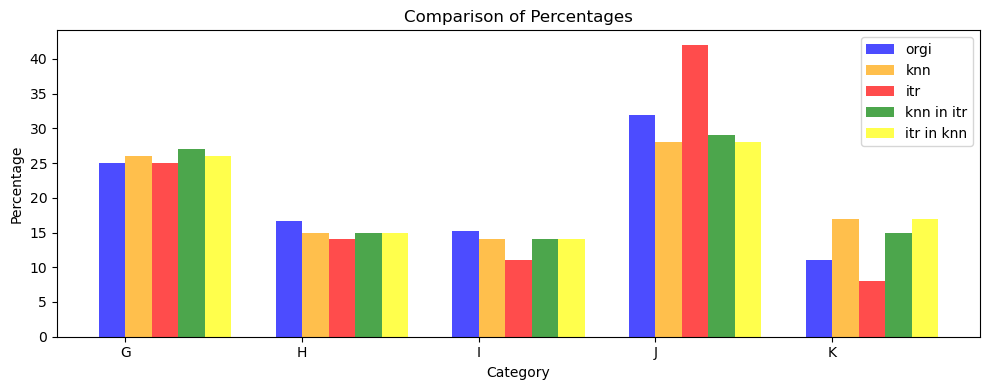

Sum of percentages for count_orginal: 100.0
Sum of percentages for count_uni: 100.0


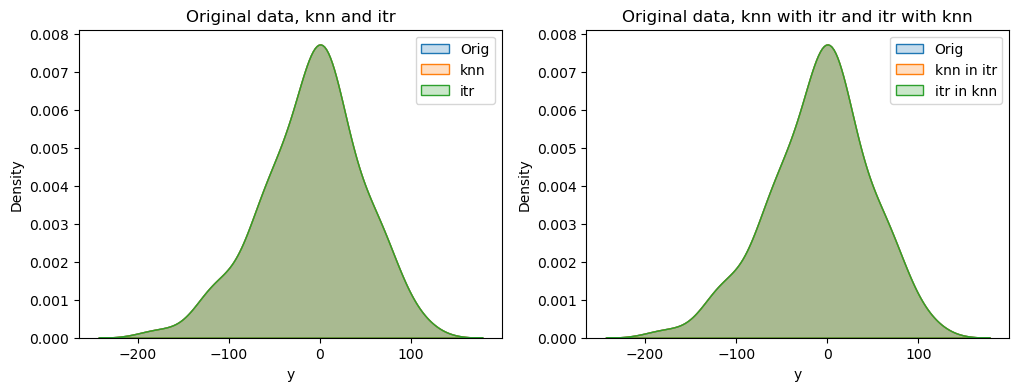

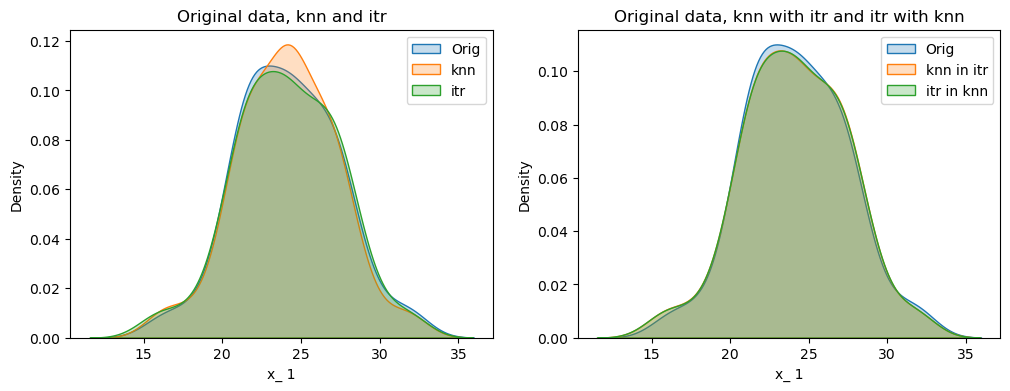

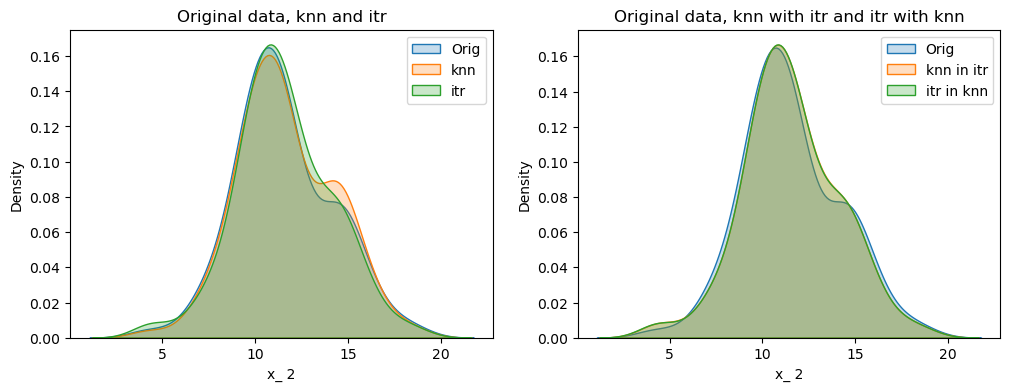

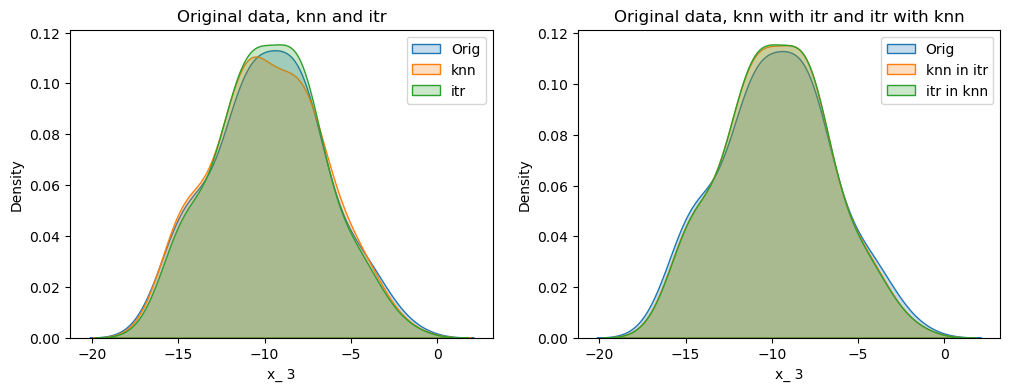

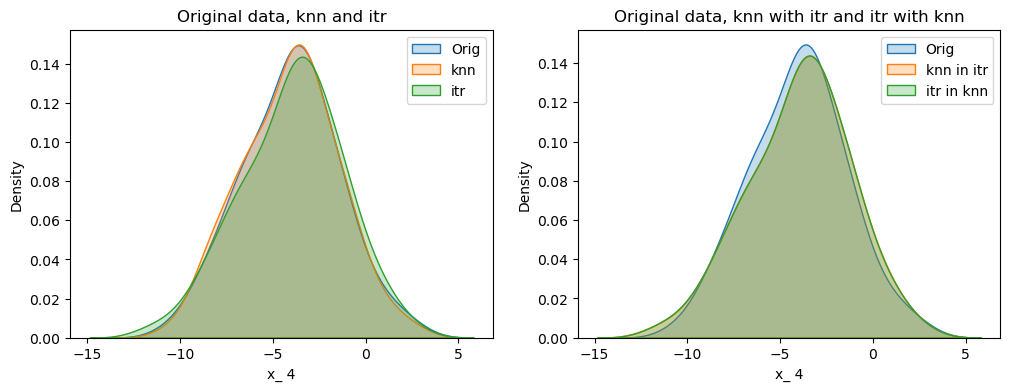

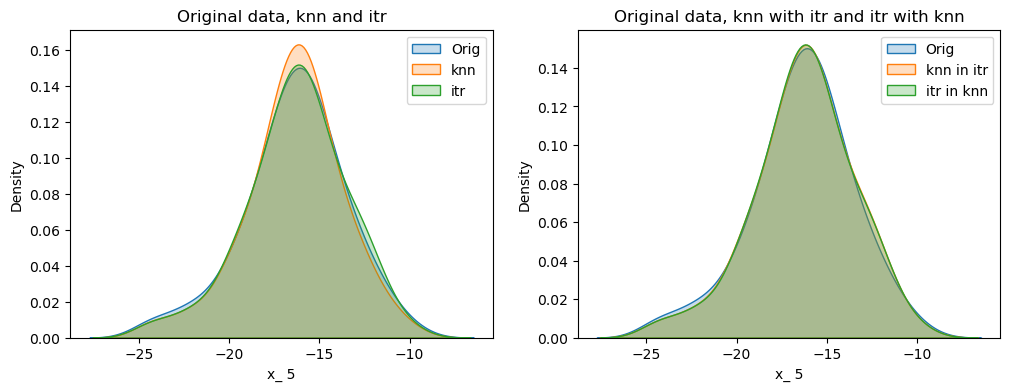

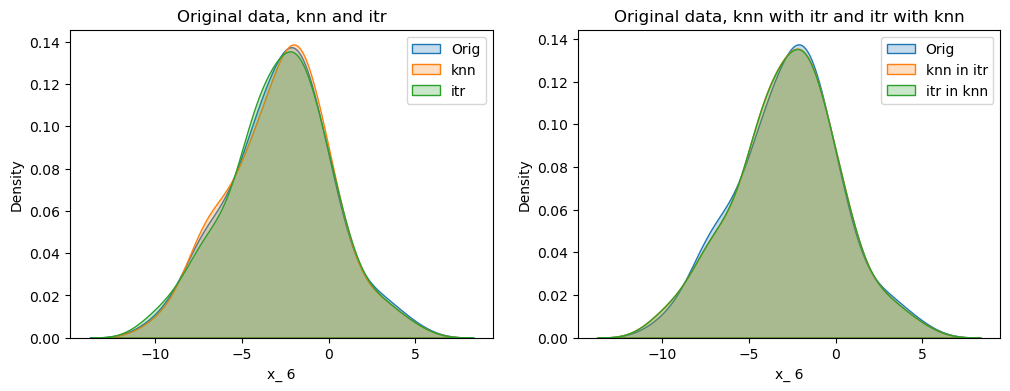

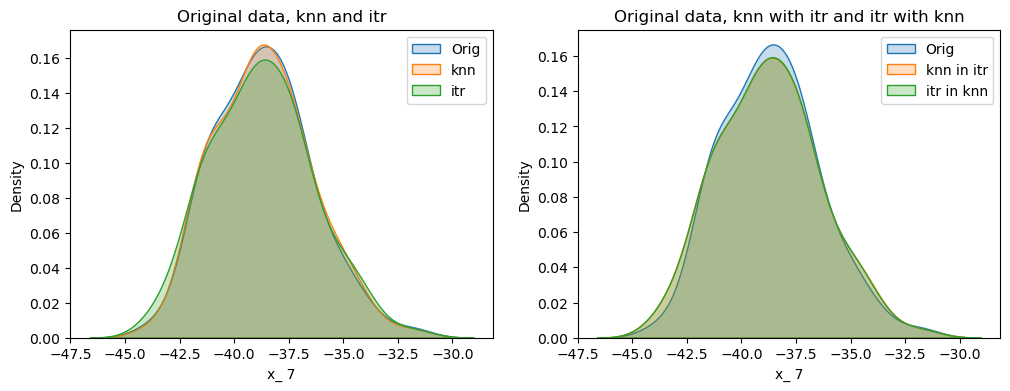

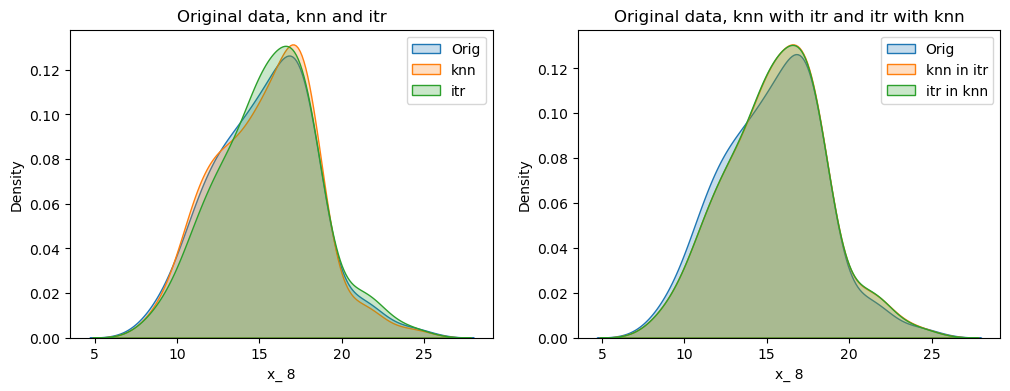

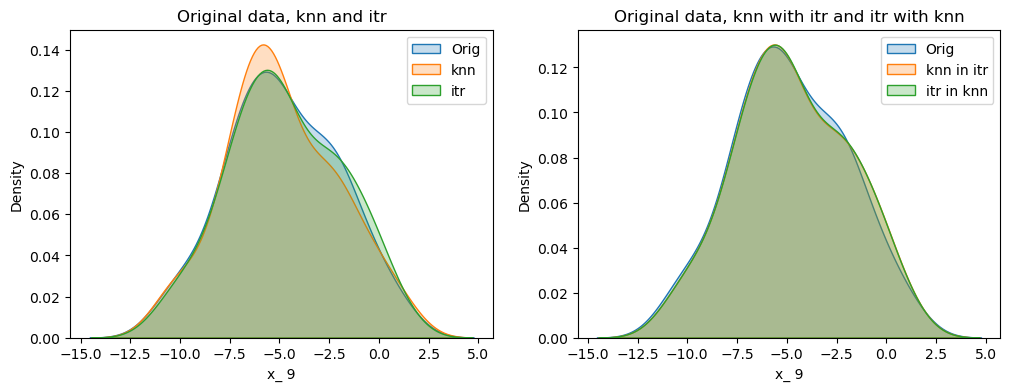

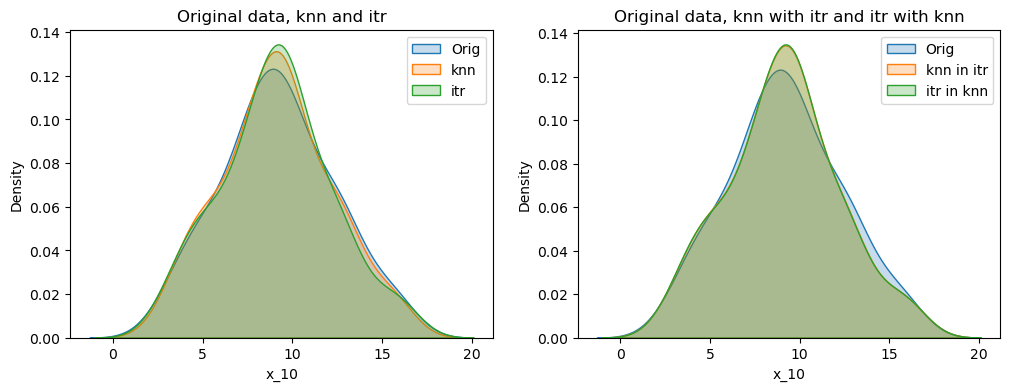

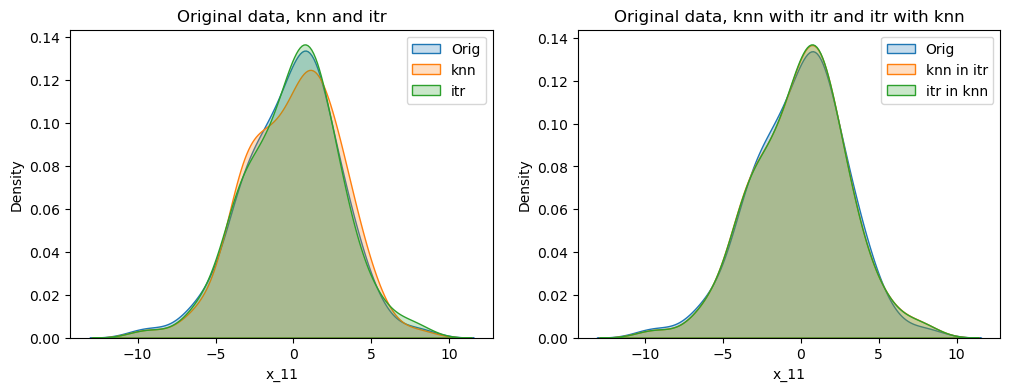

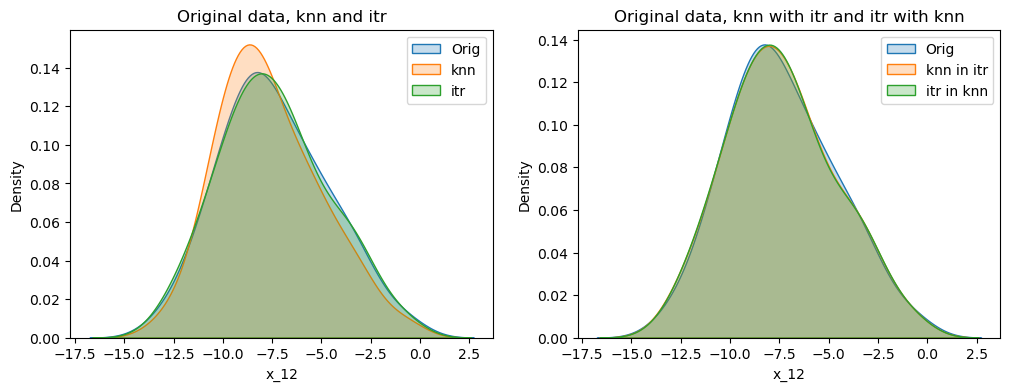

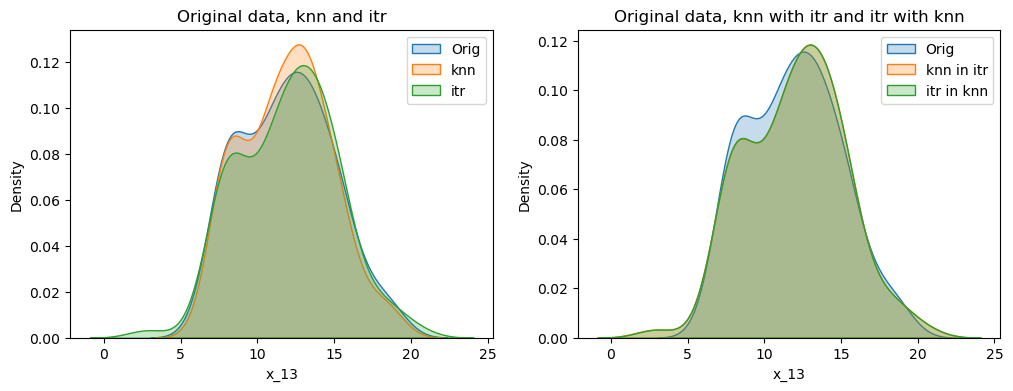

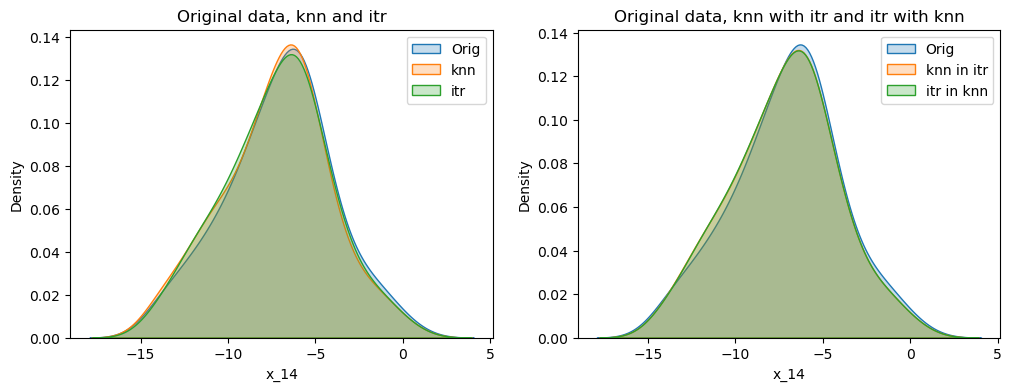

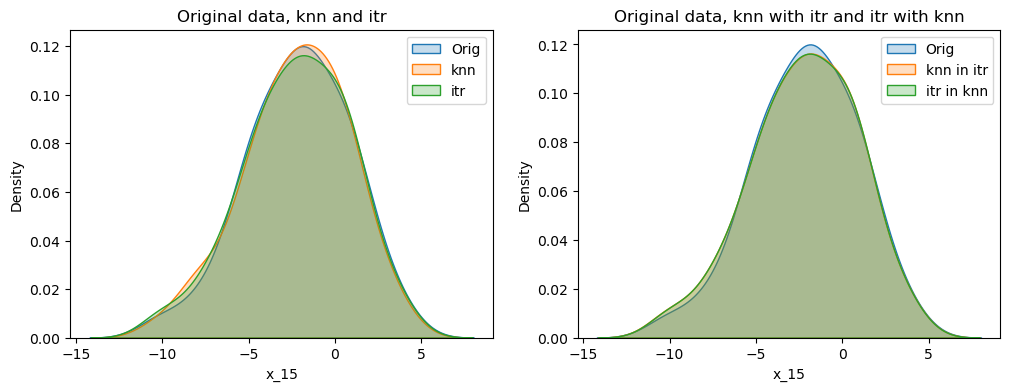

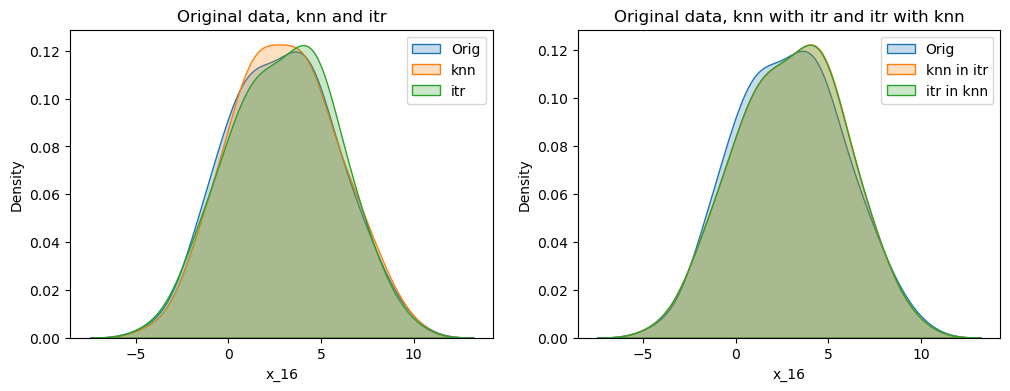

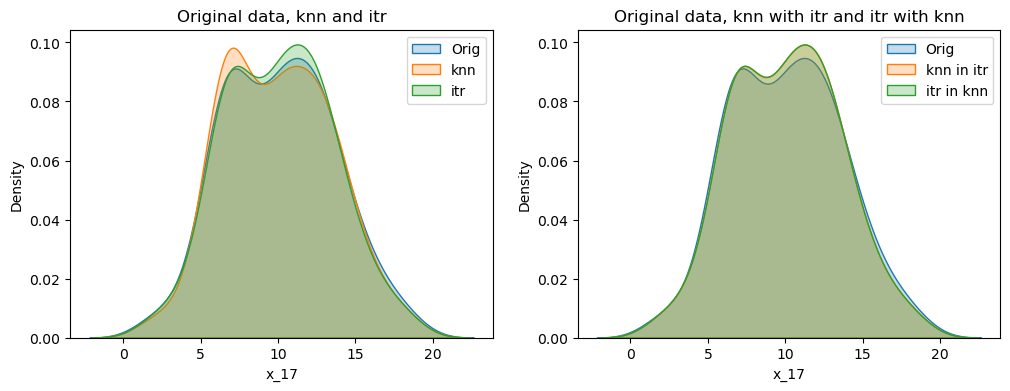

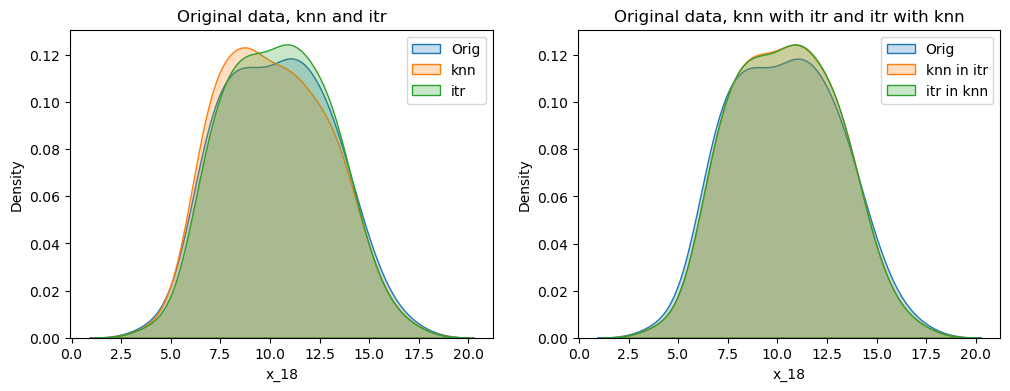

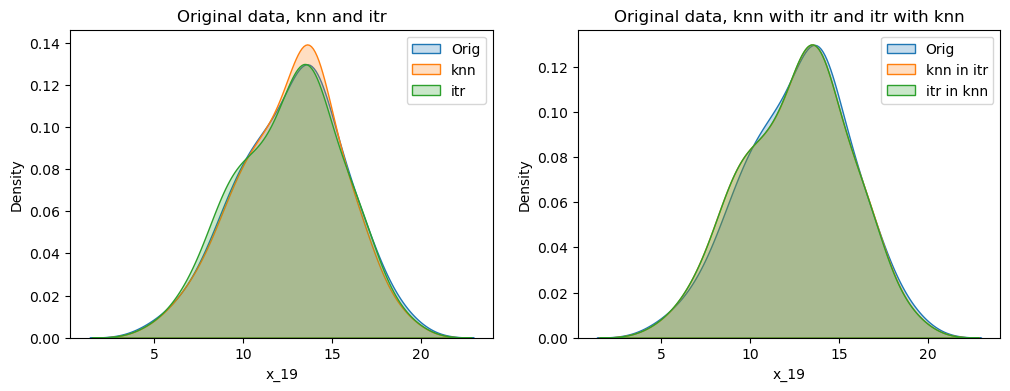

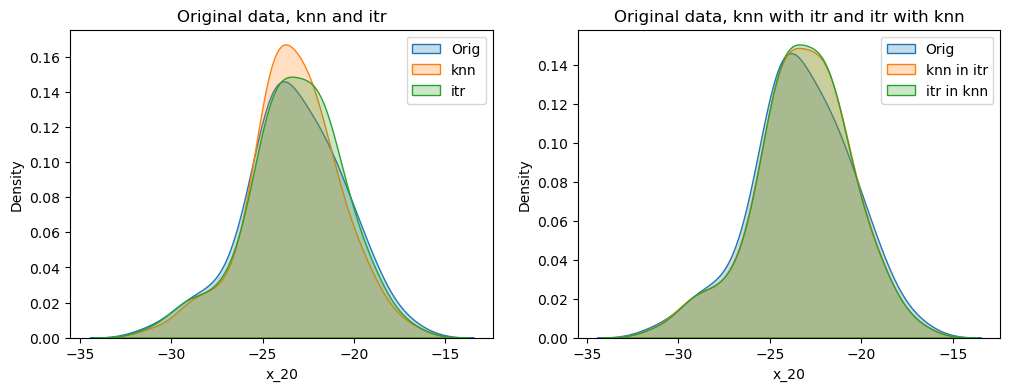

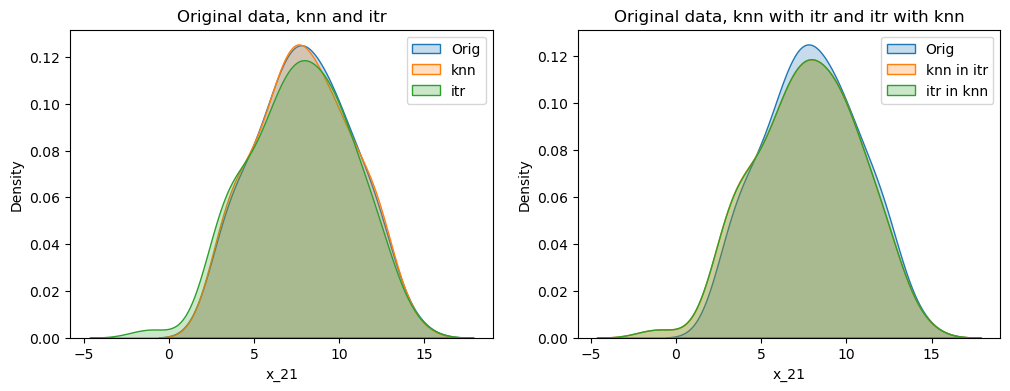

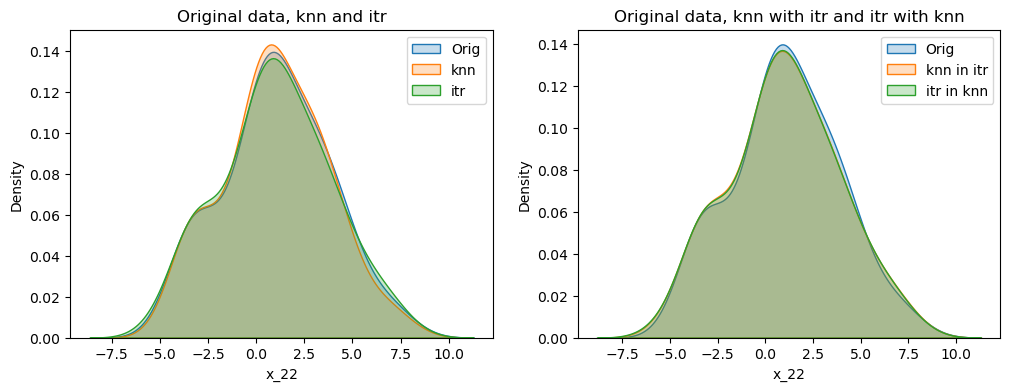

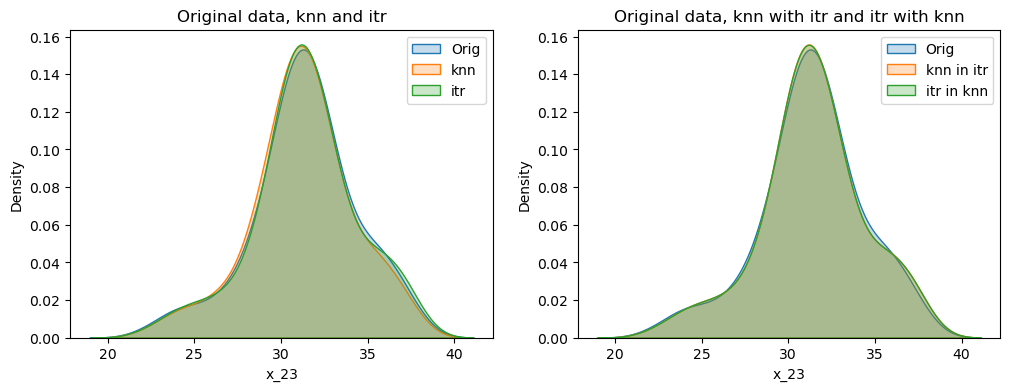

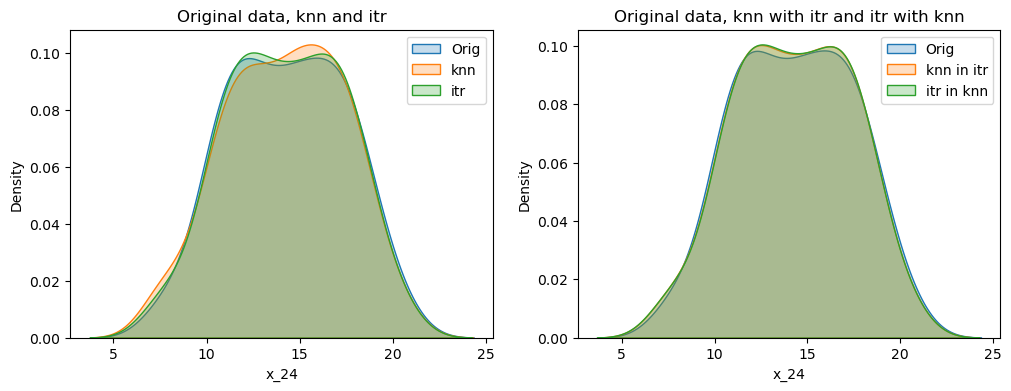

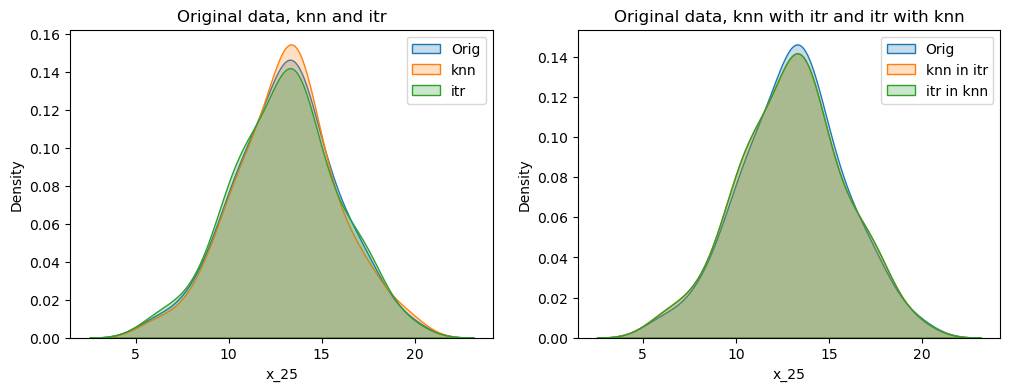

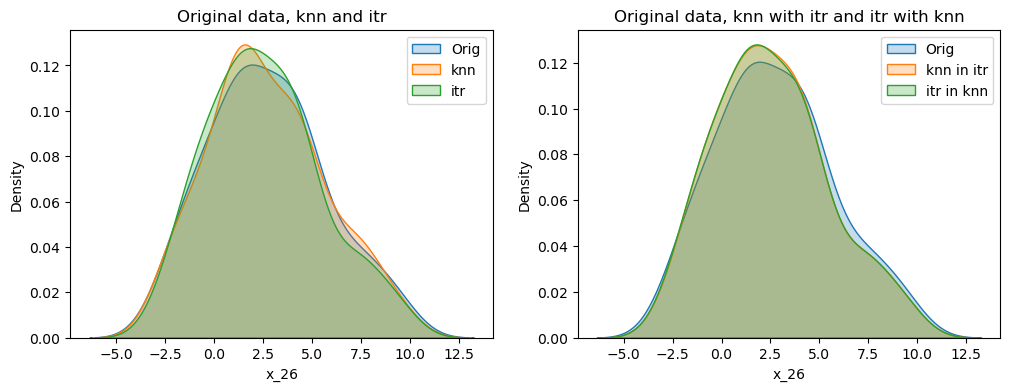

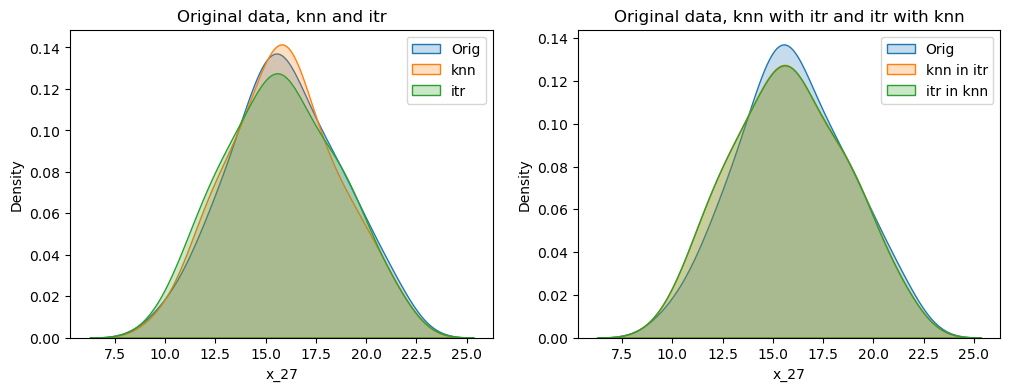

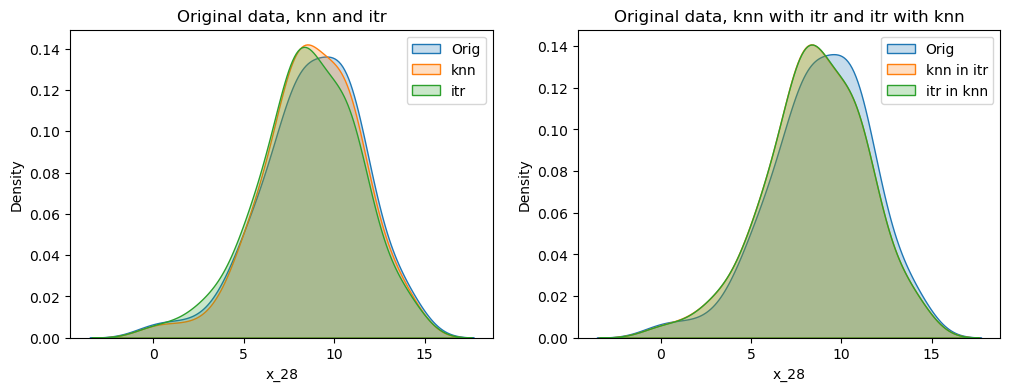

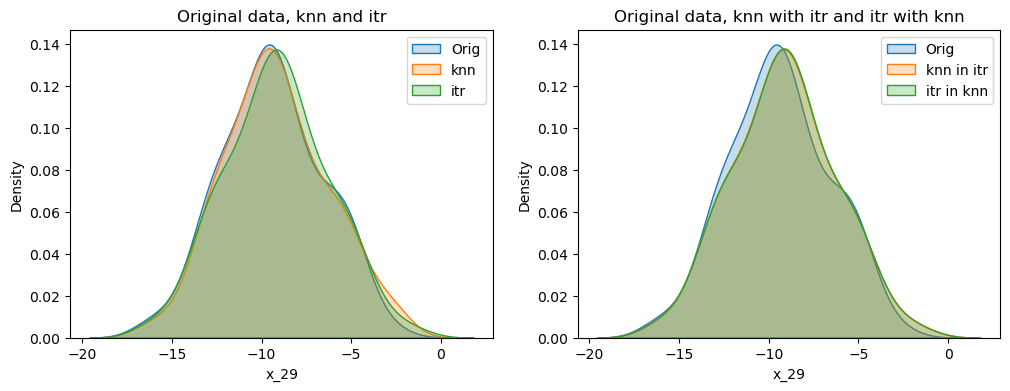

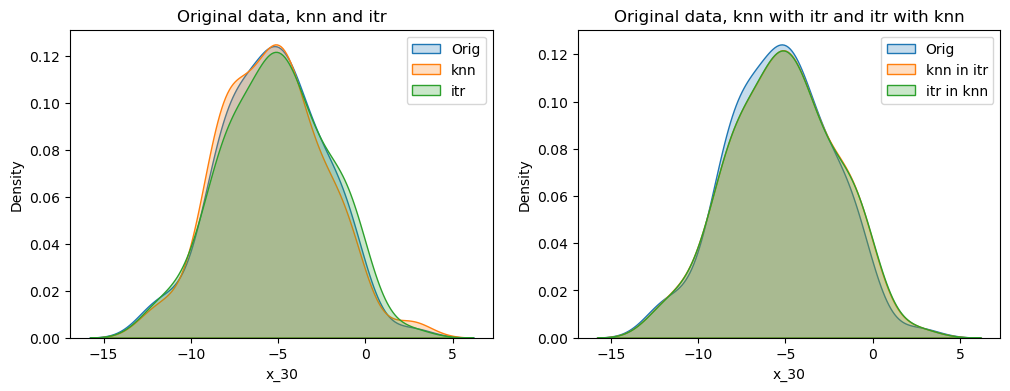

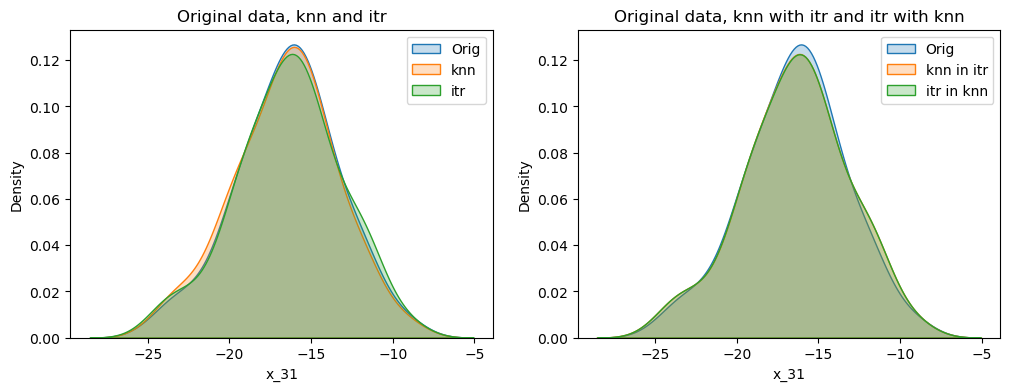

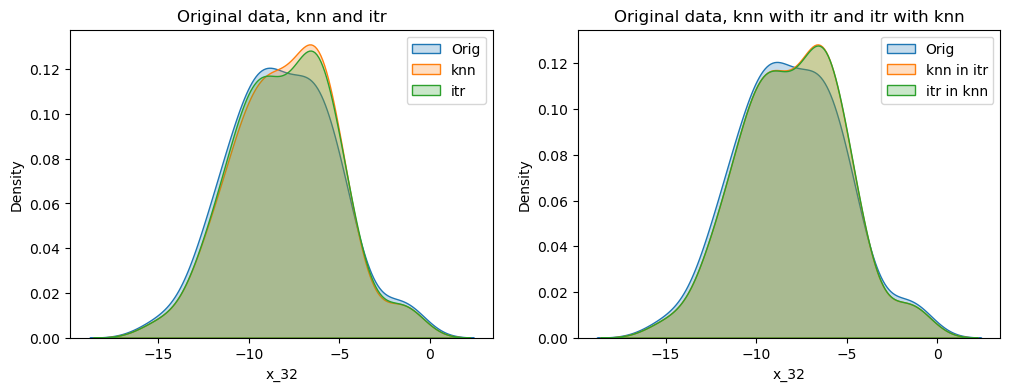

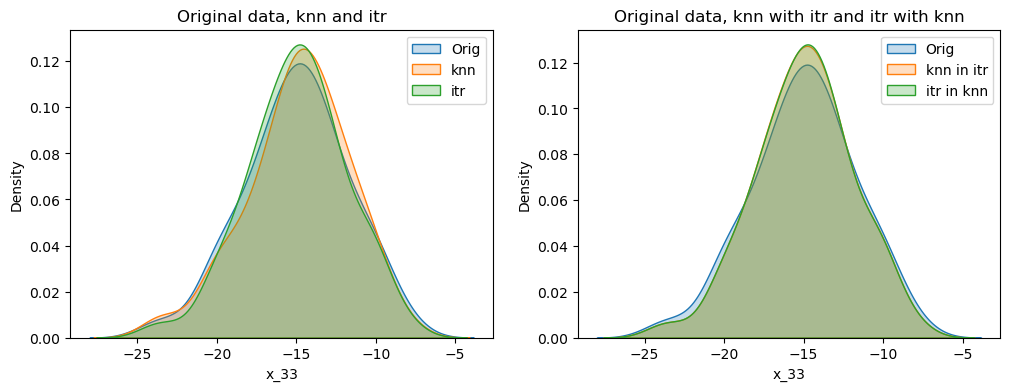

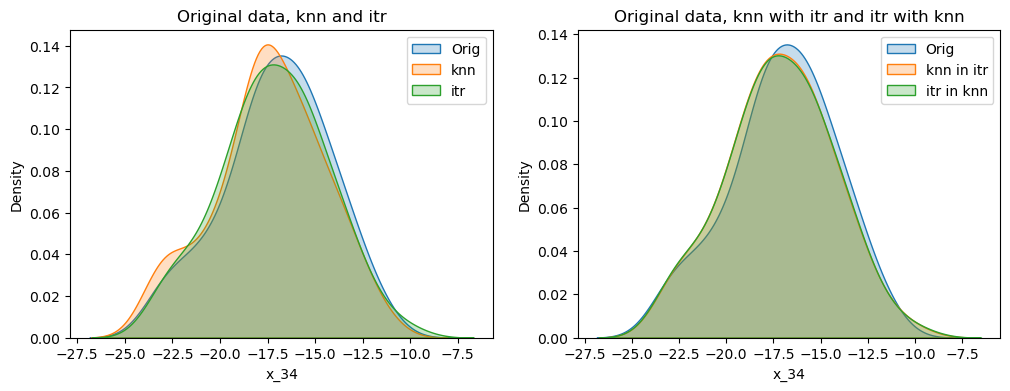

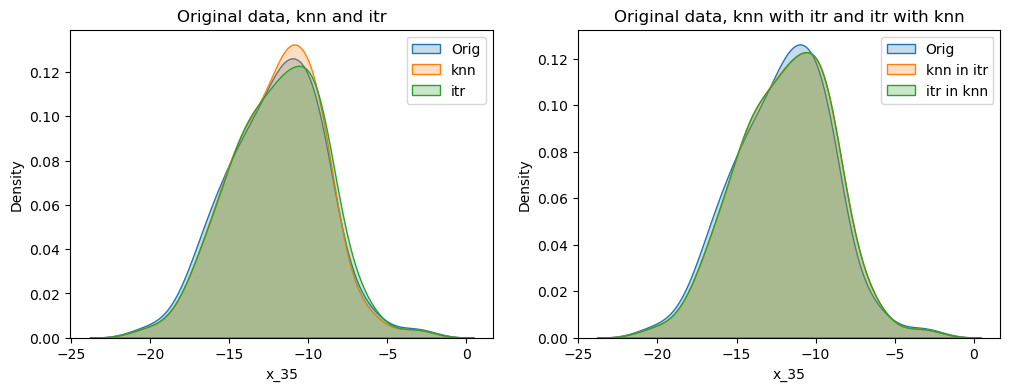

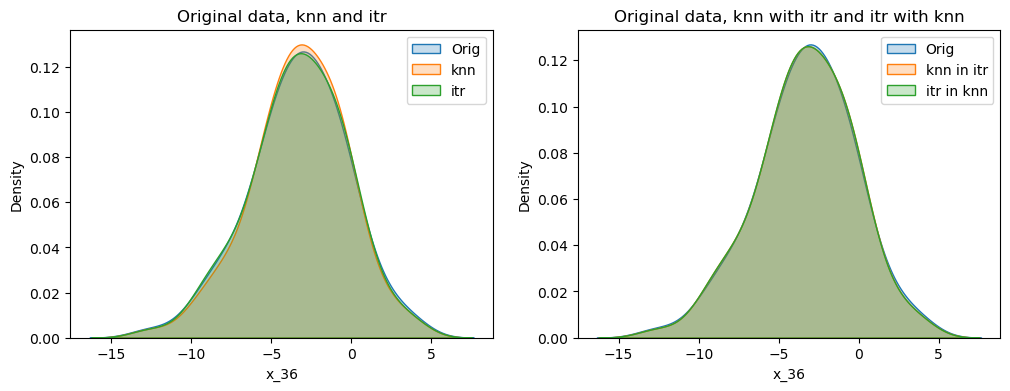

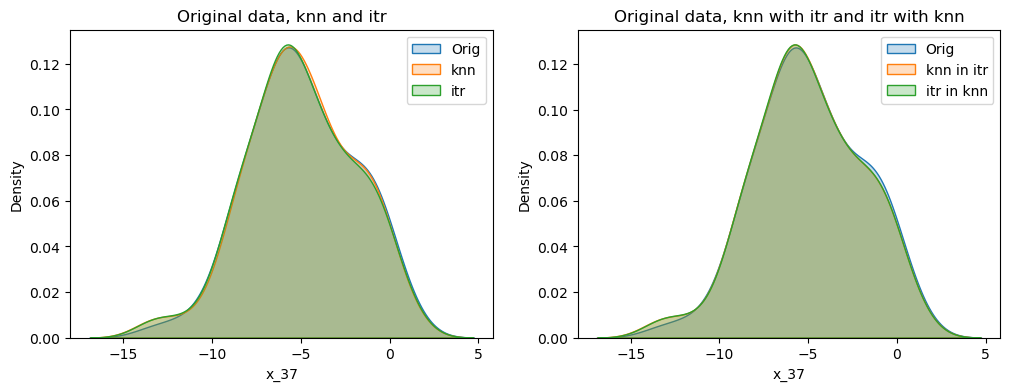

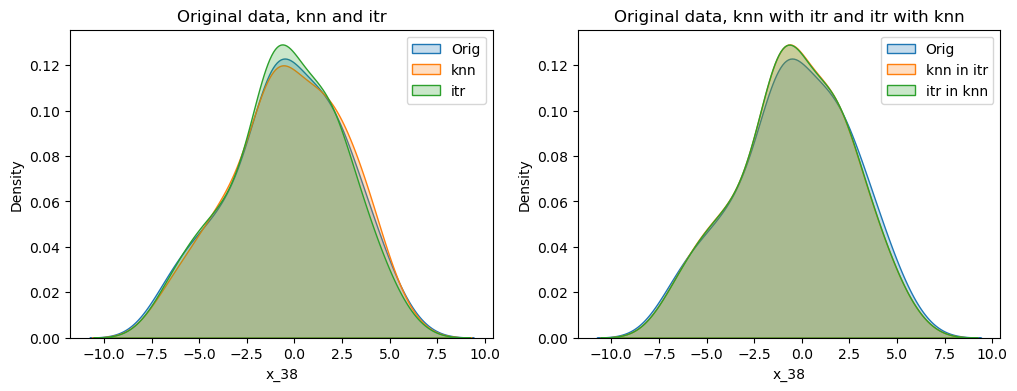

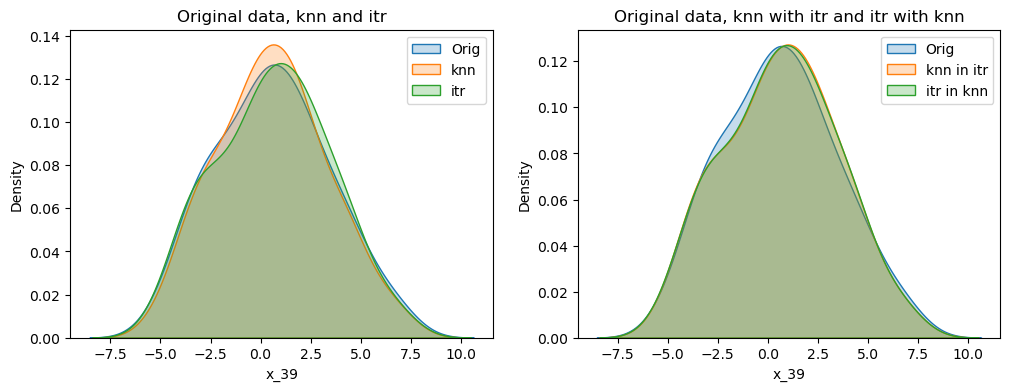

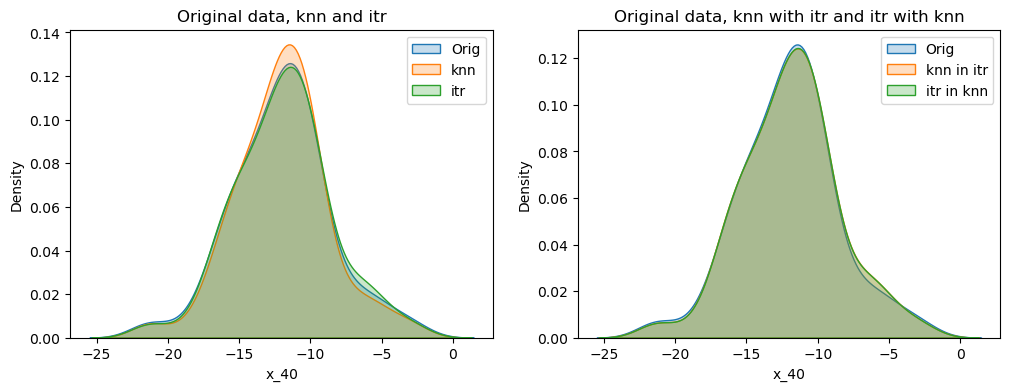

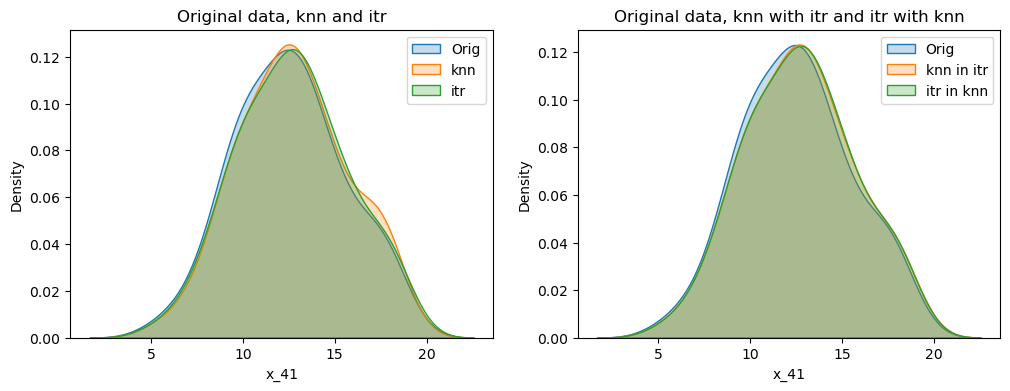

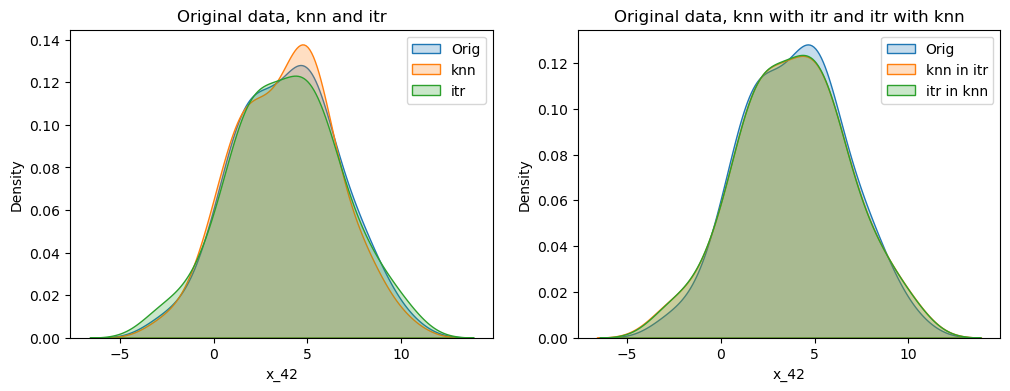

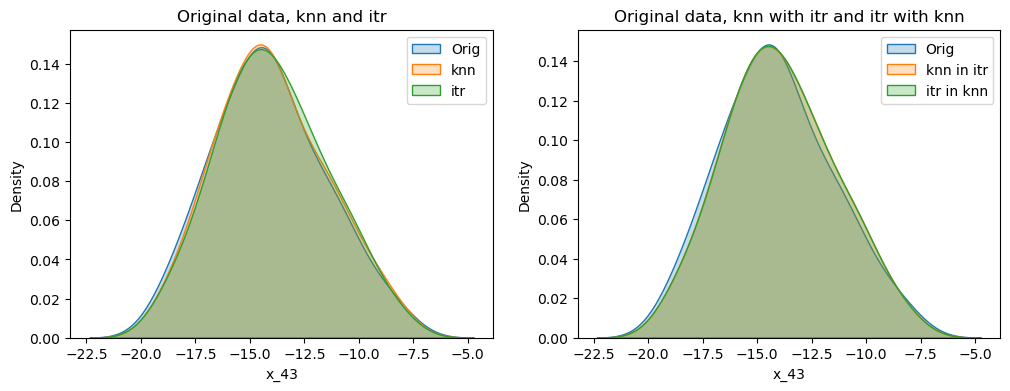

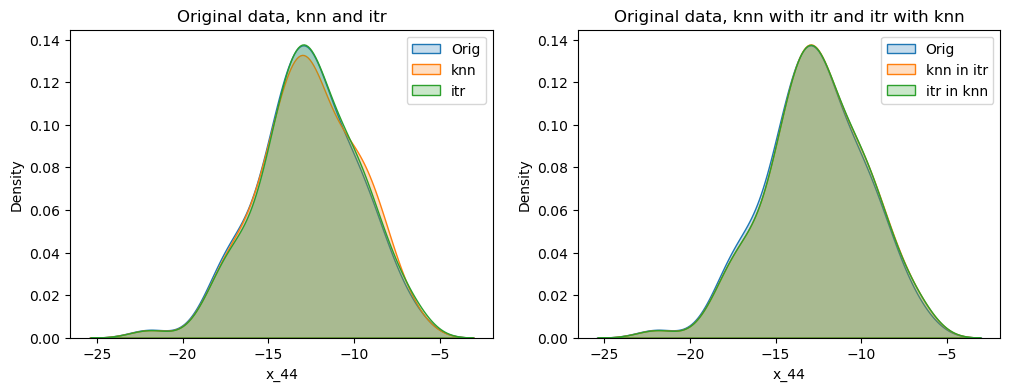

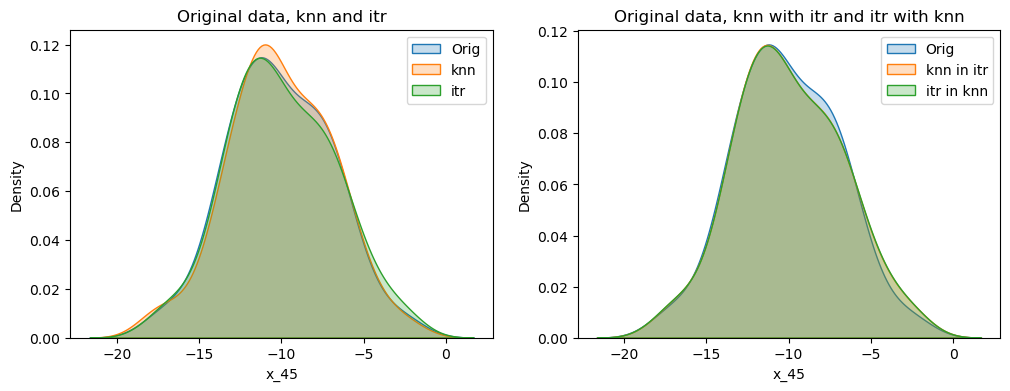

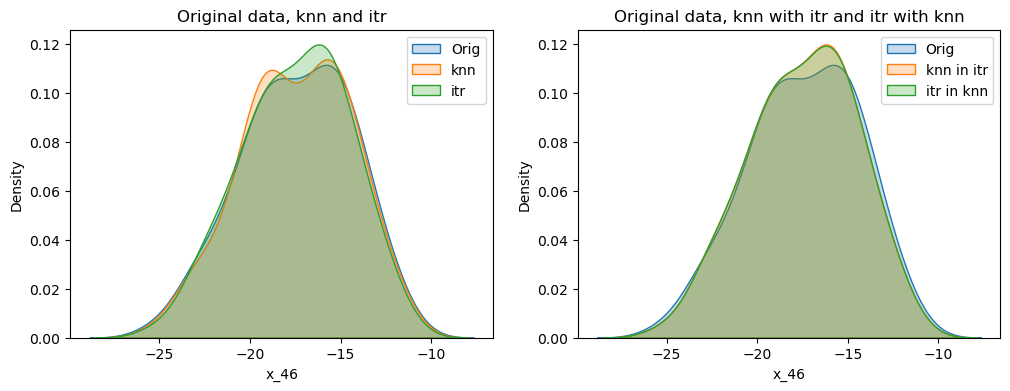

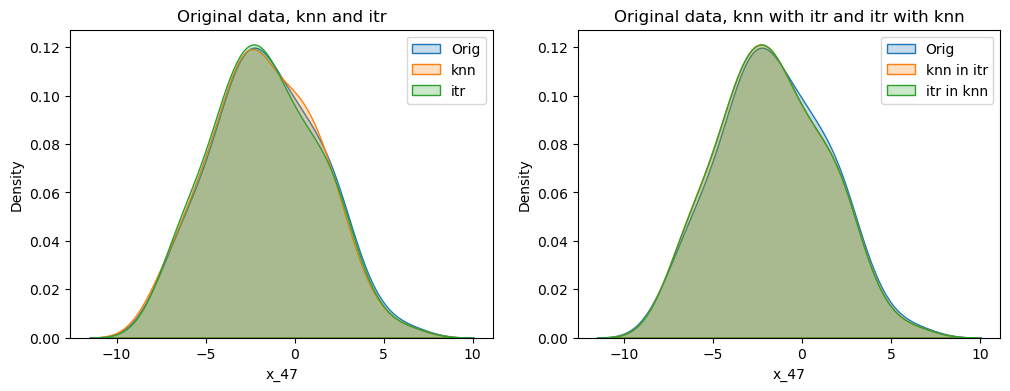

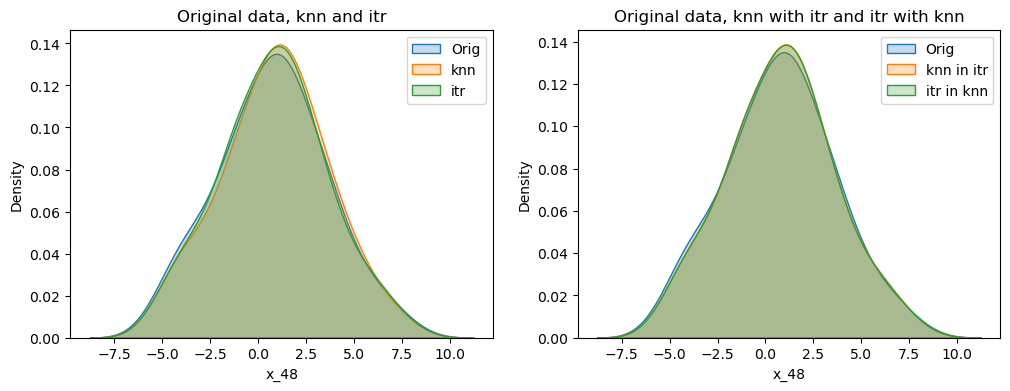

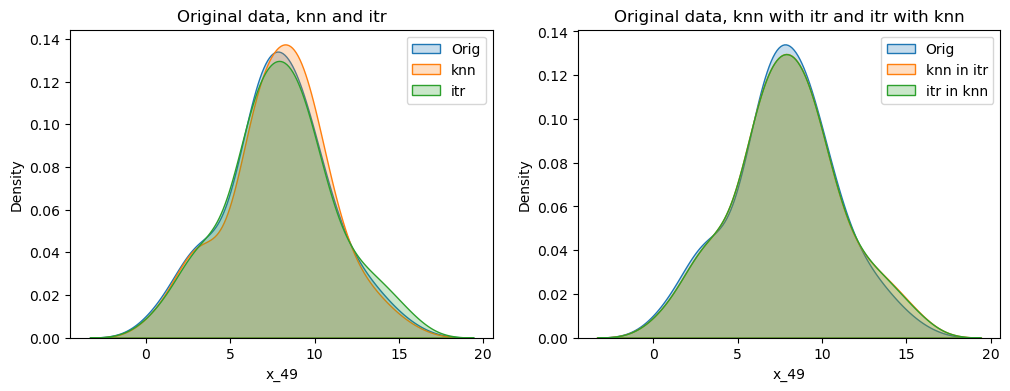

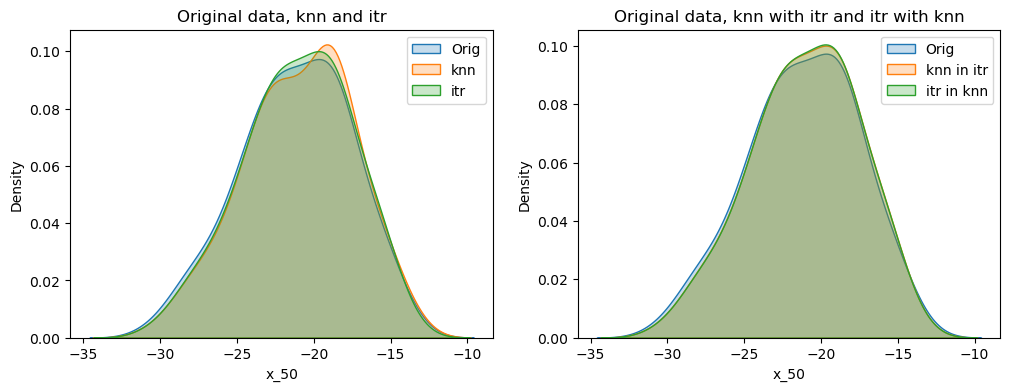

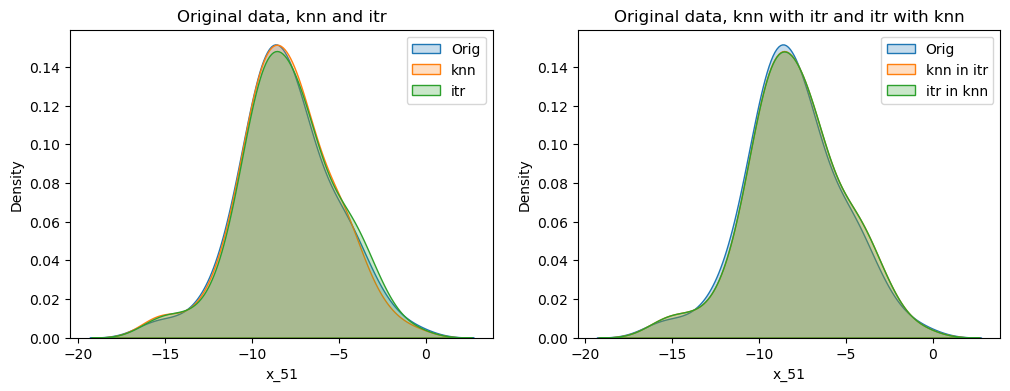

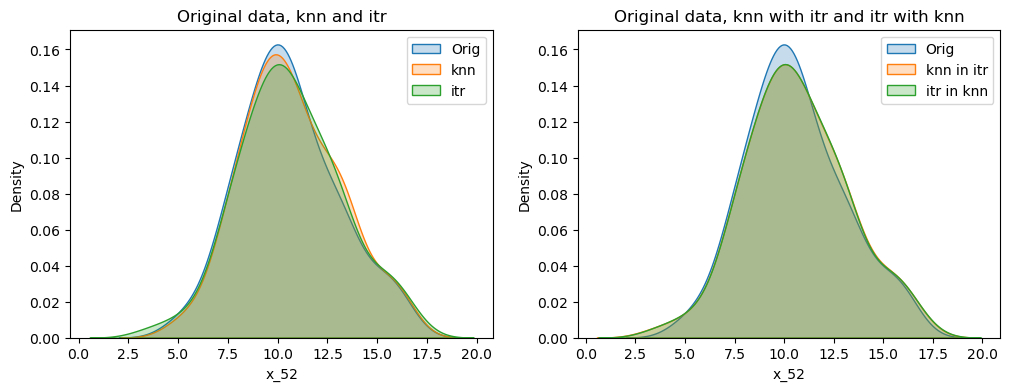

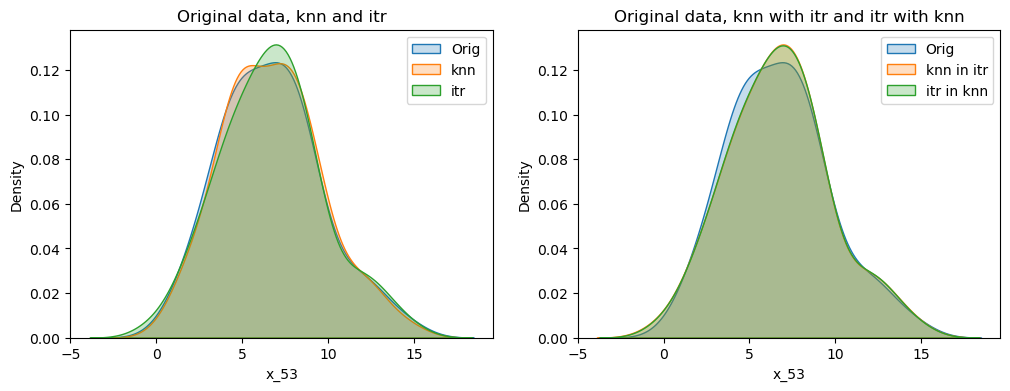

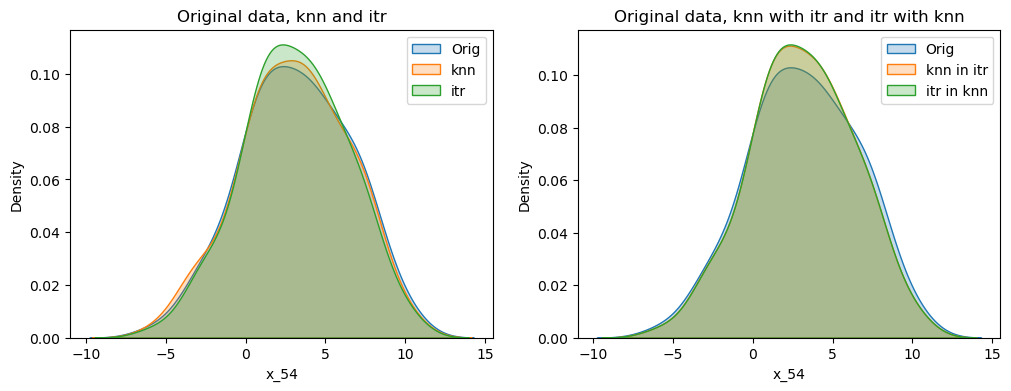

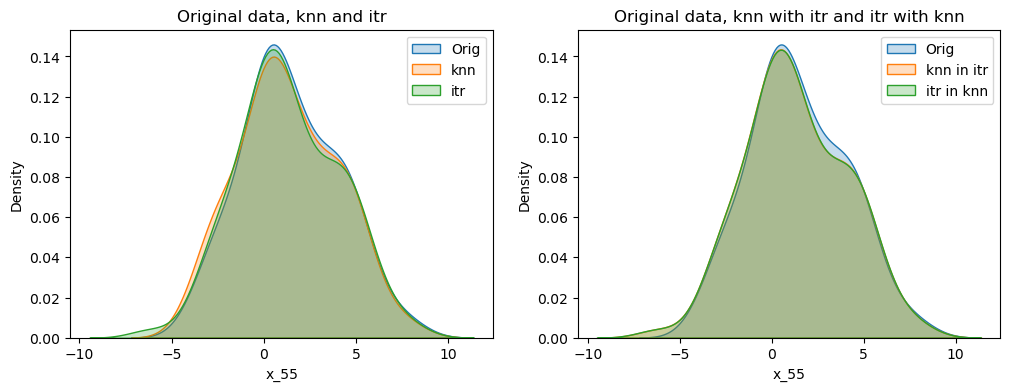

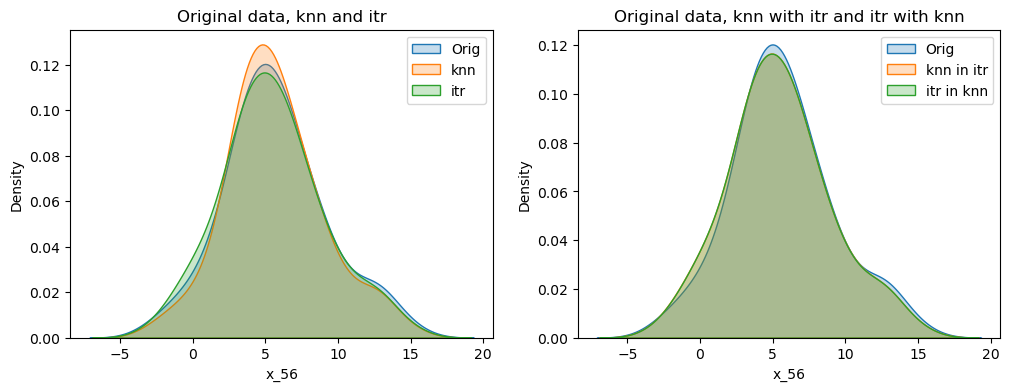

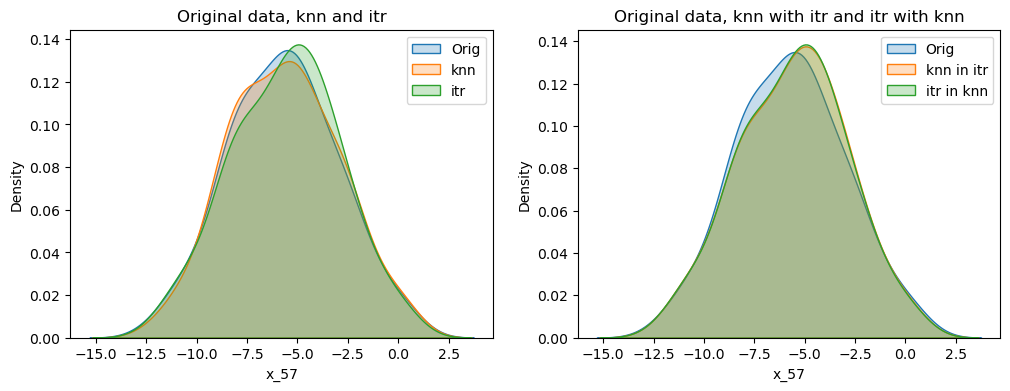

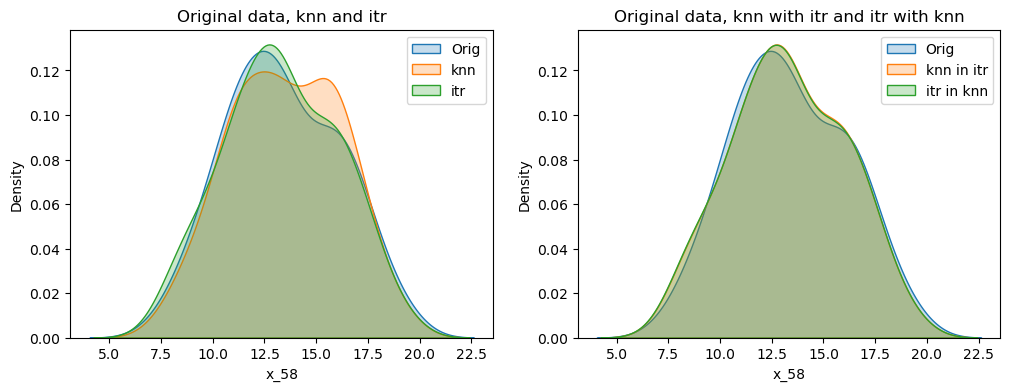

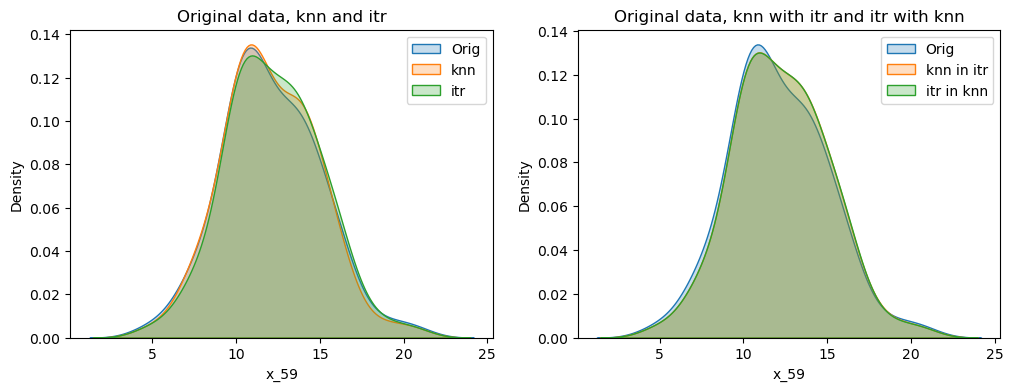

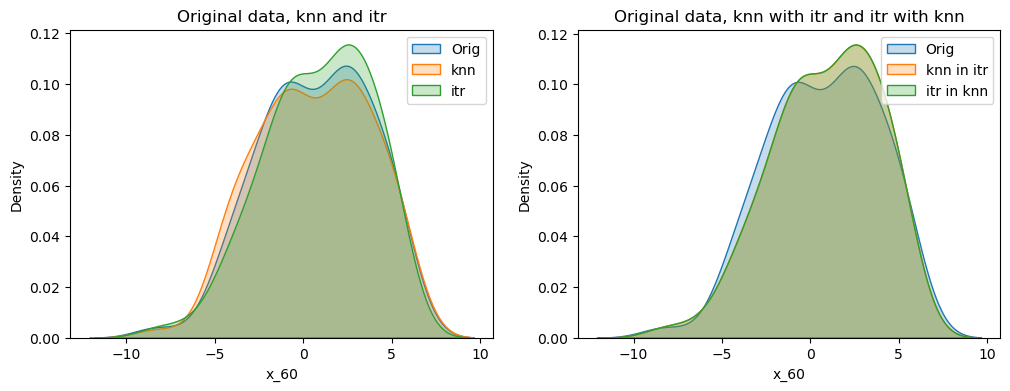

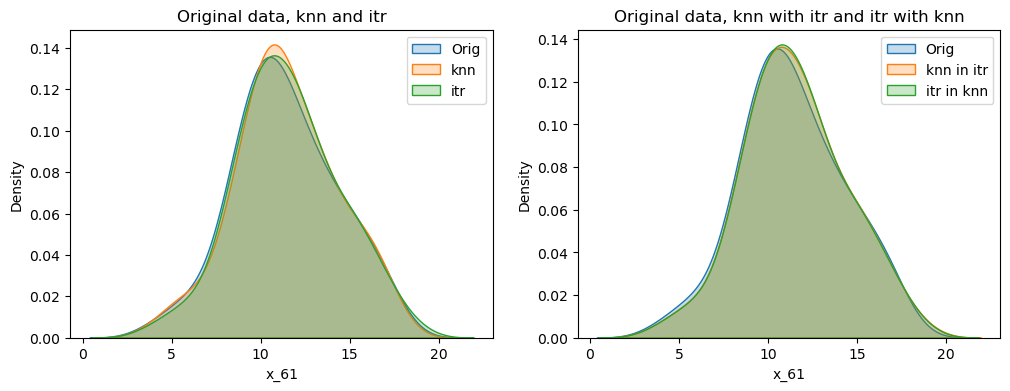

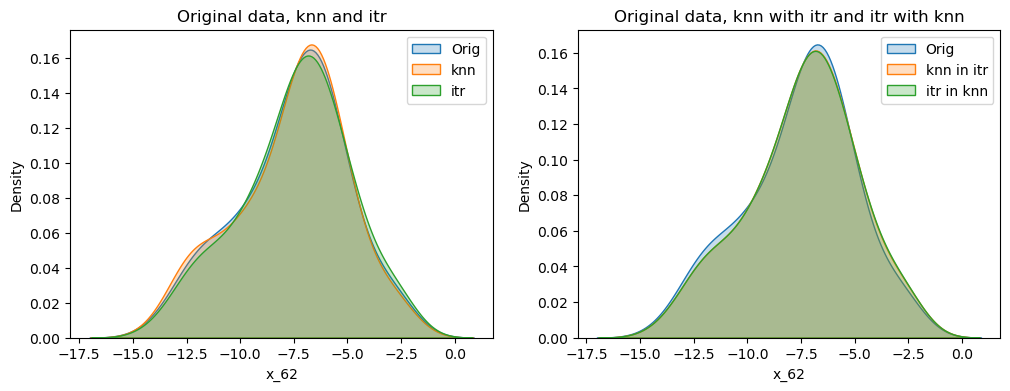

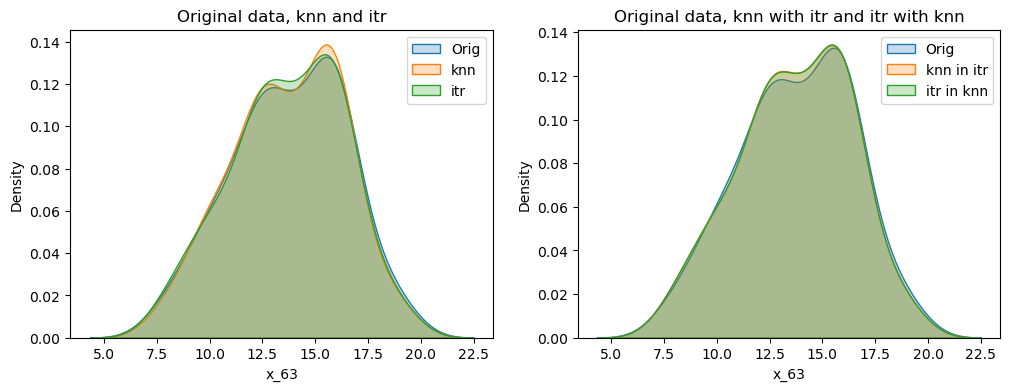

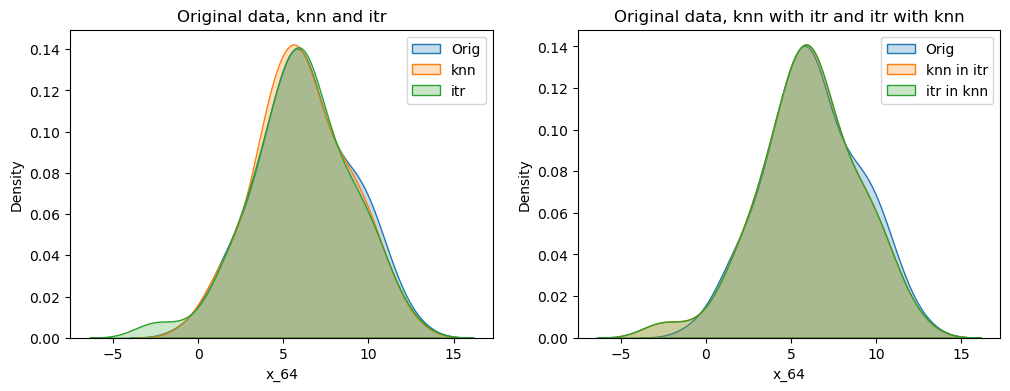

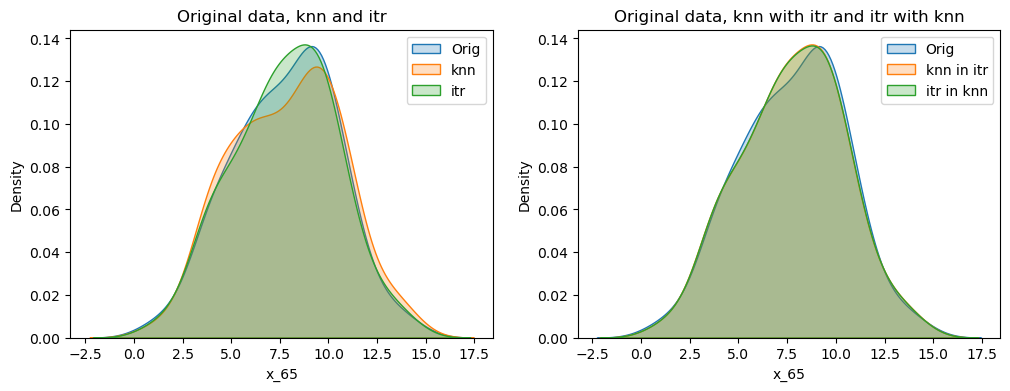

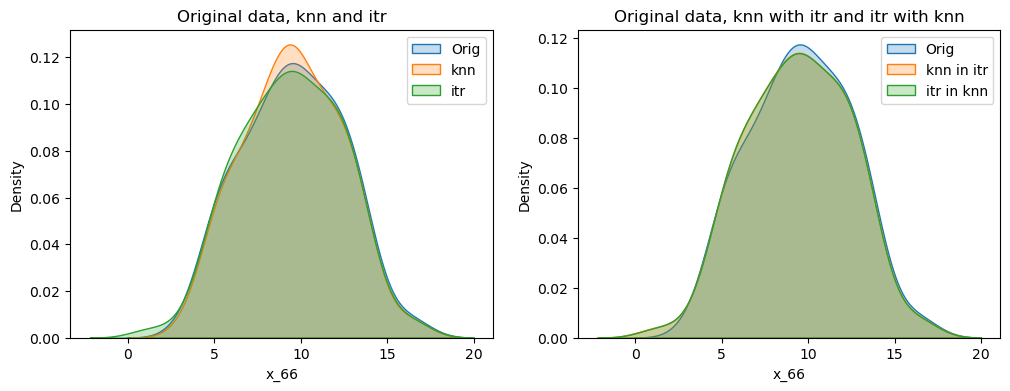

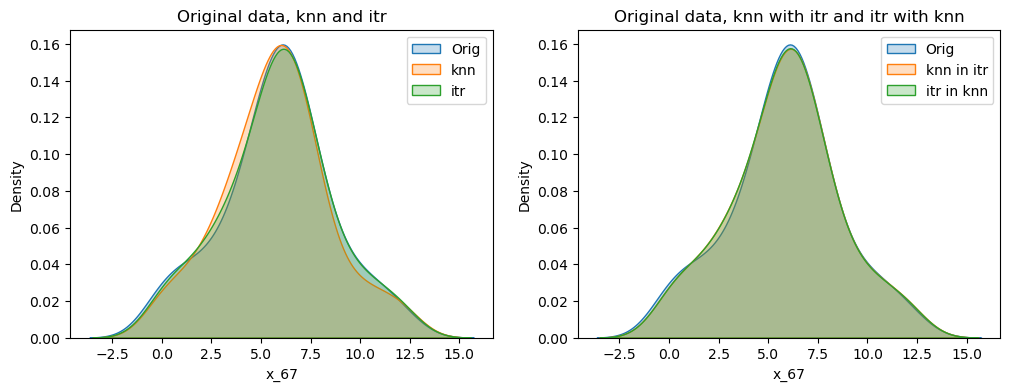

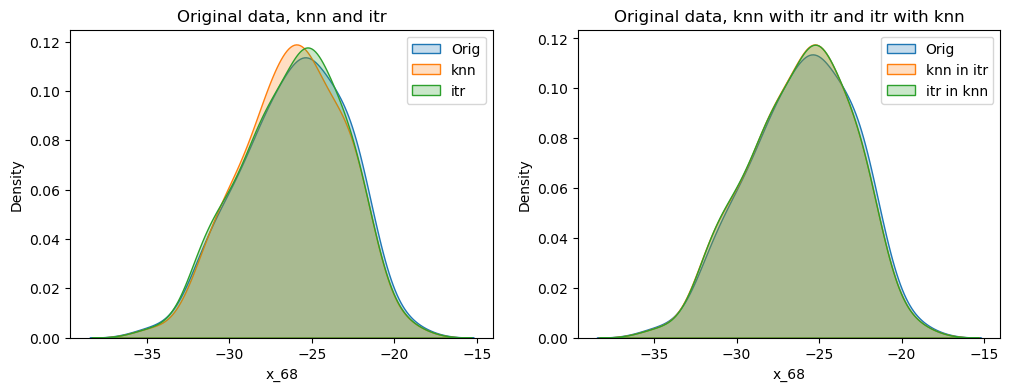

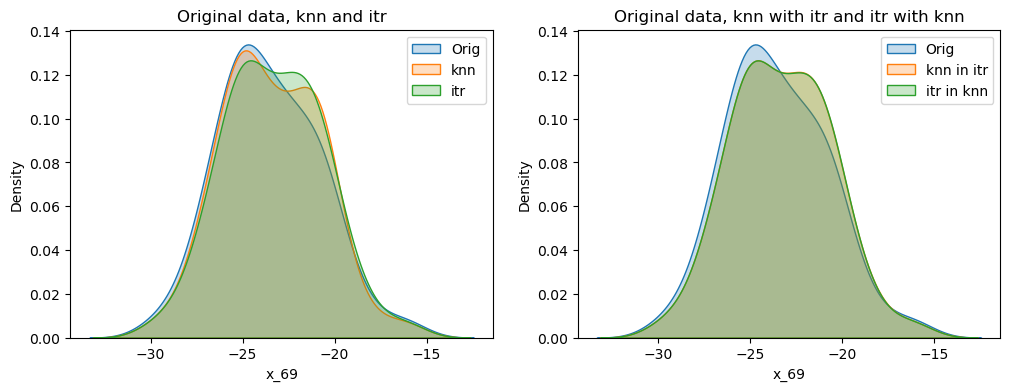

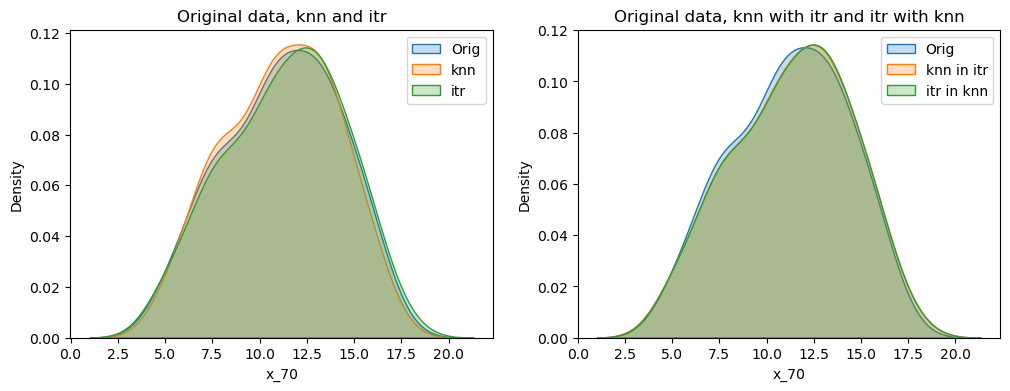

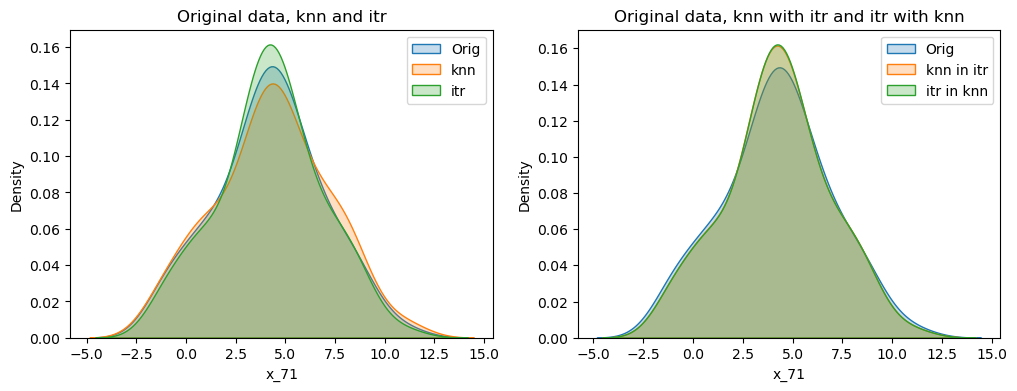

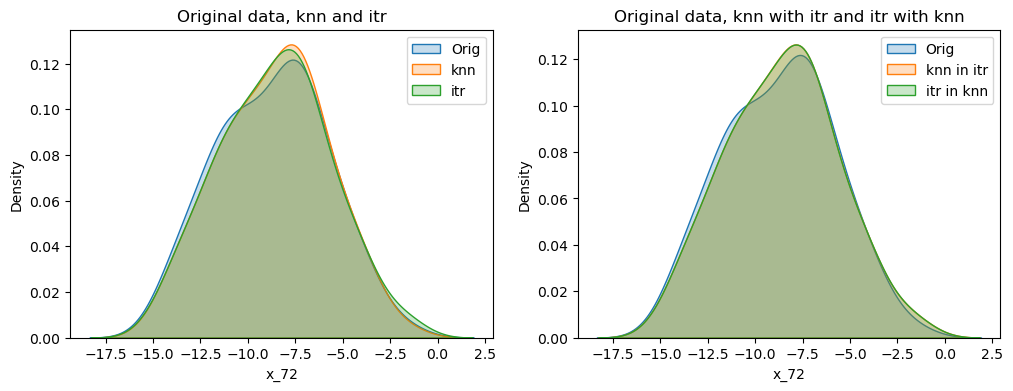

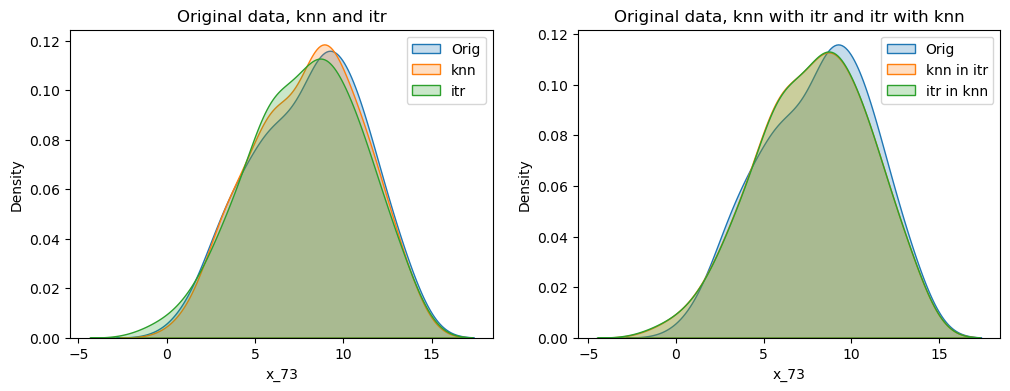

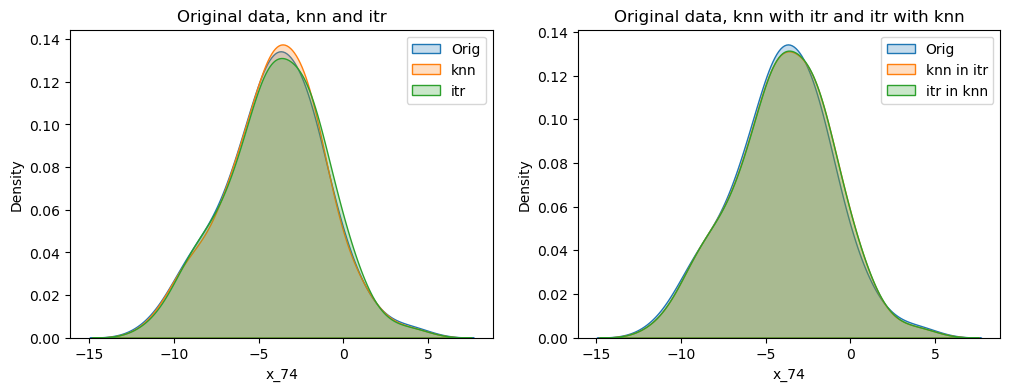

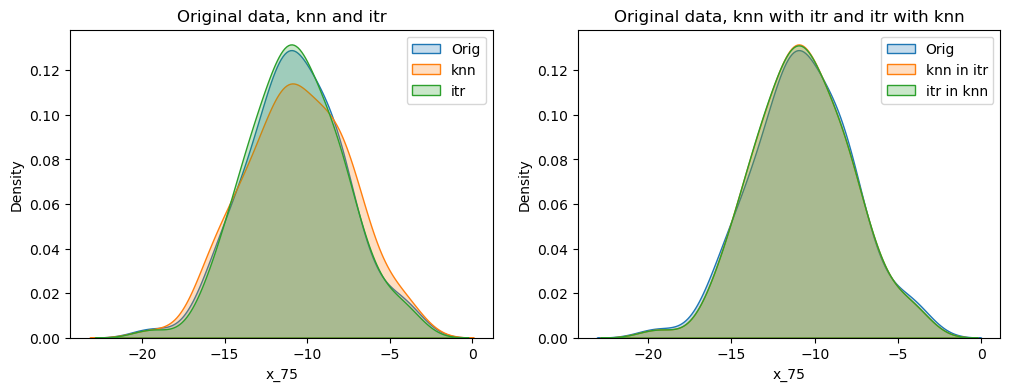

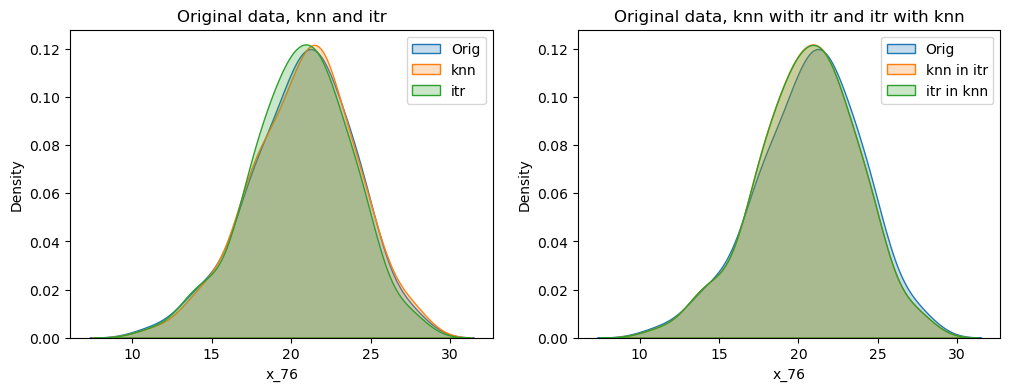

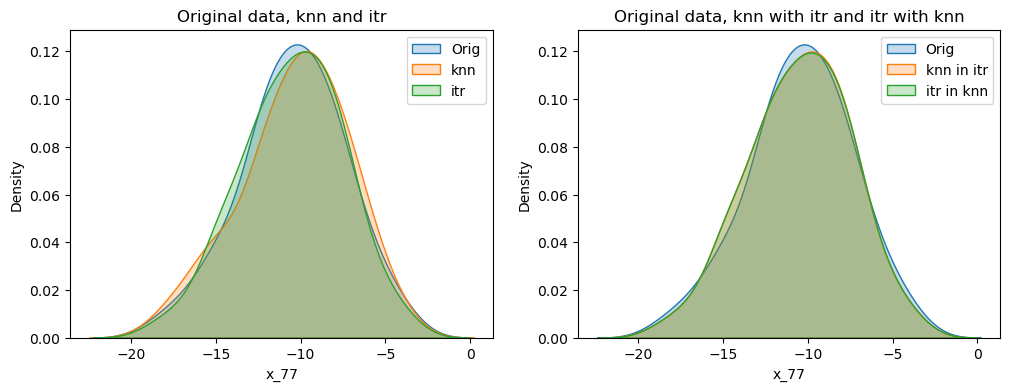

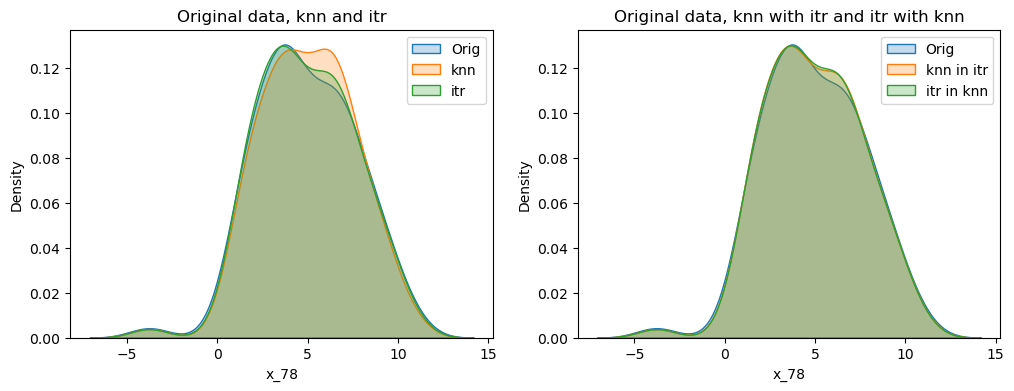

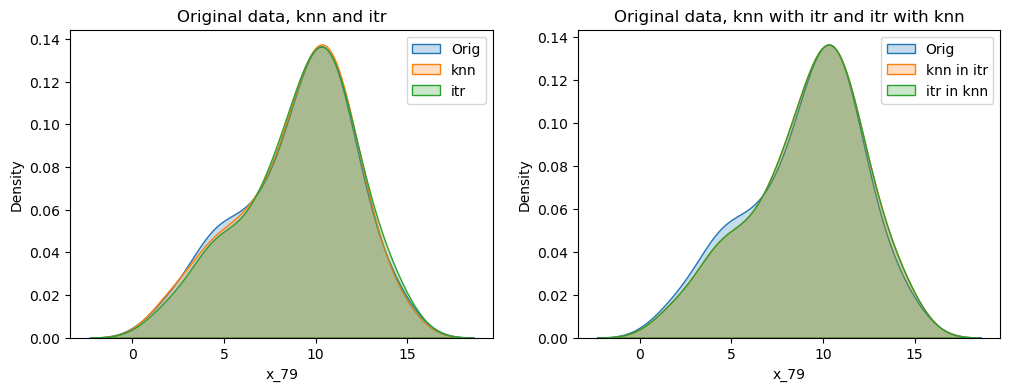

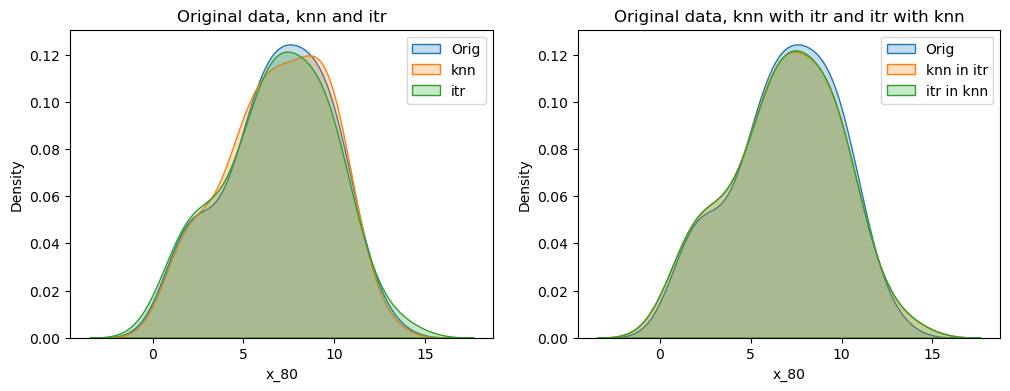

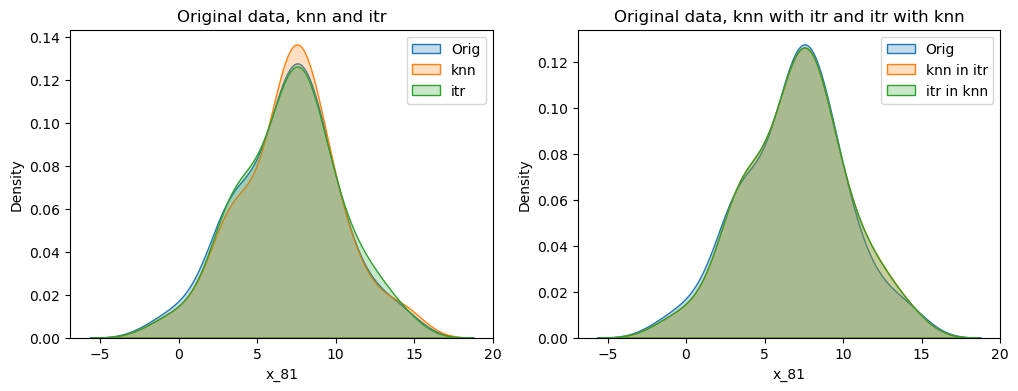

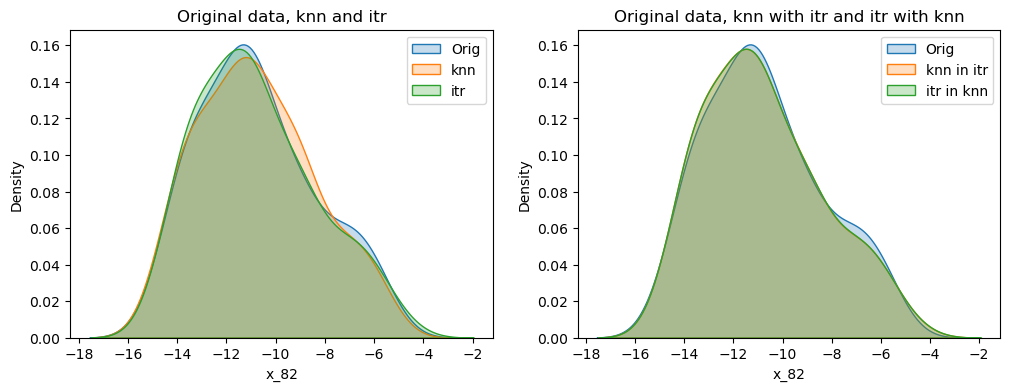

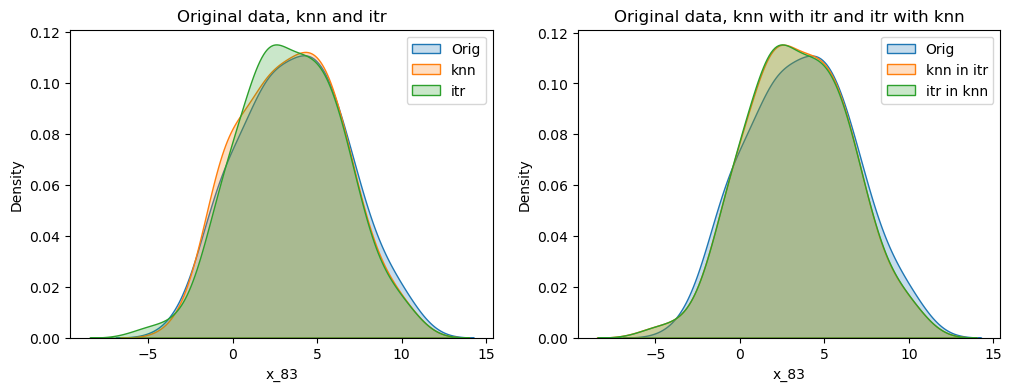

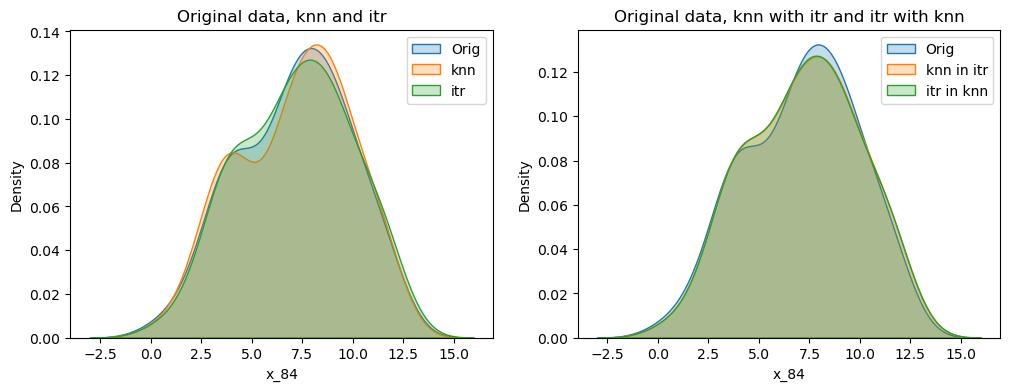

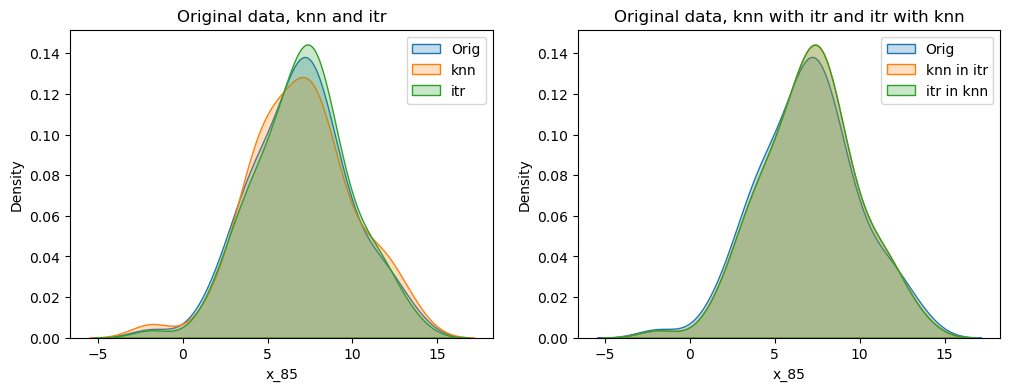

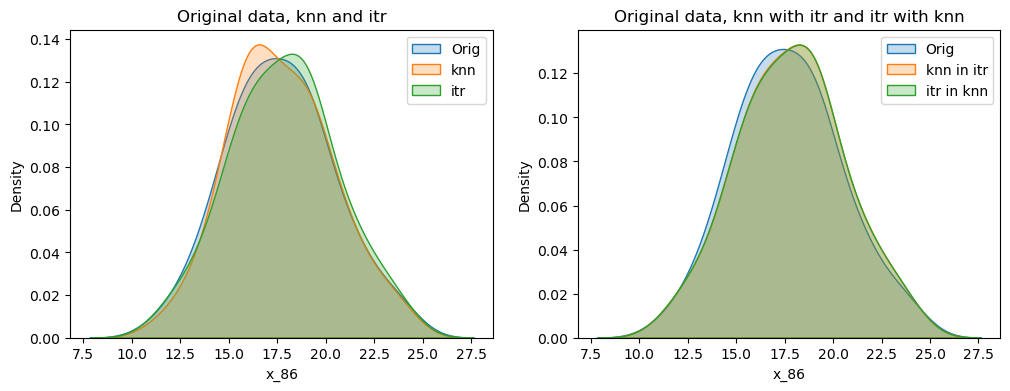

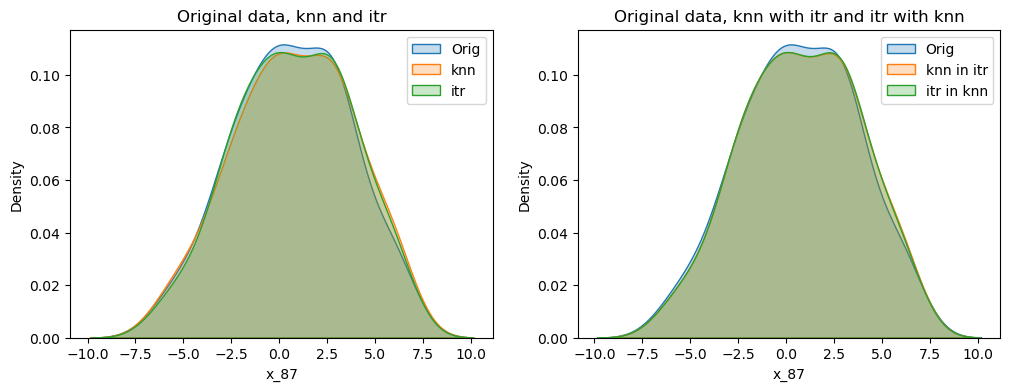

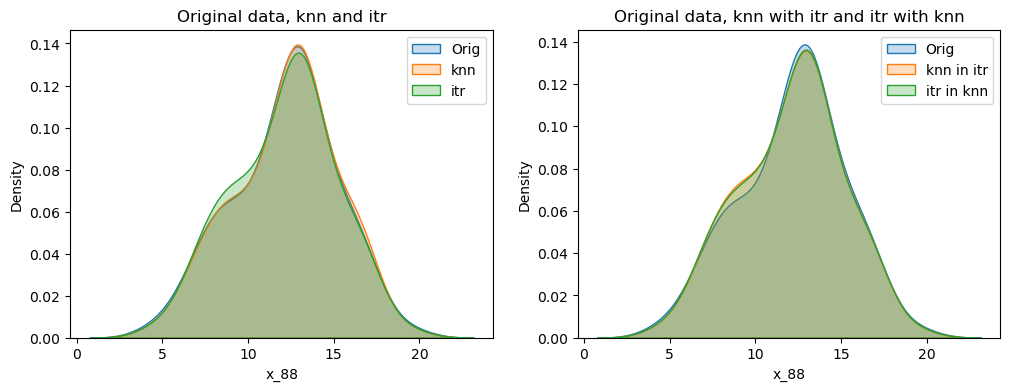

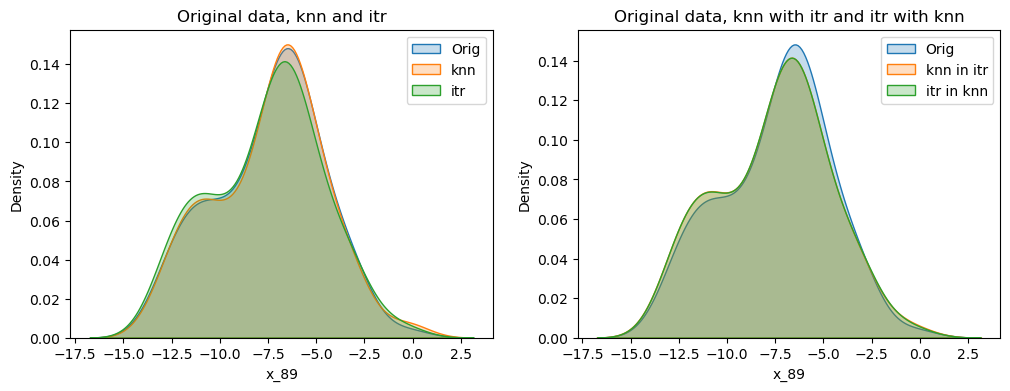

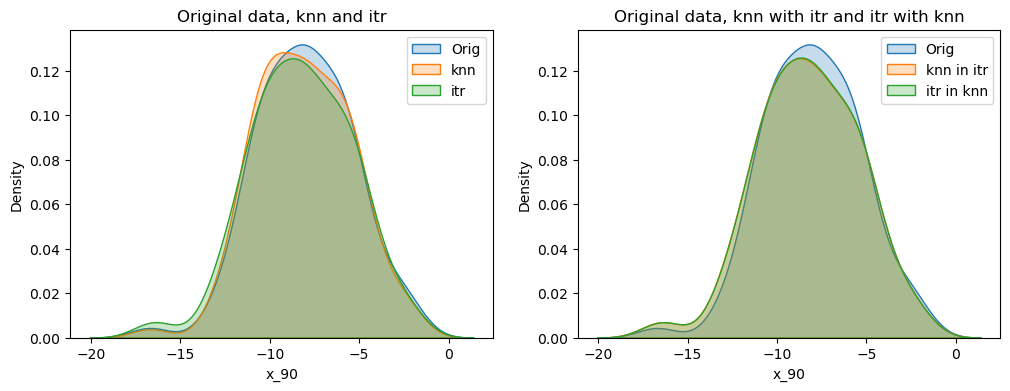

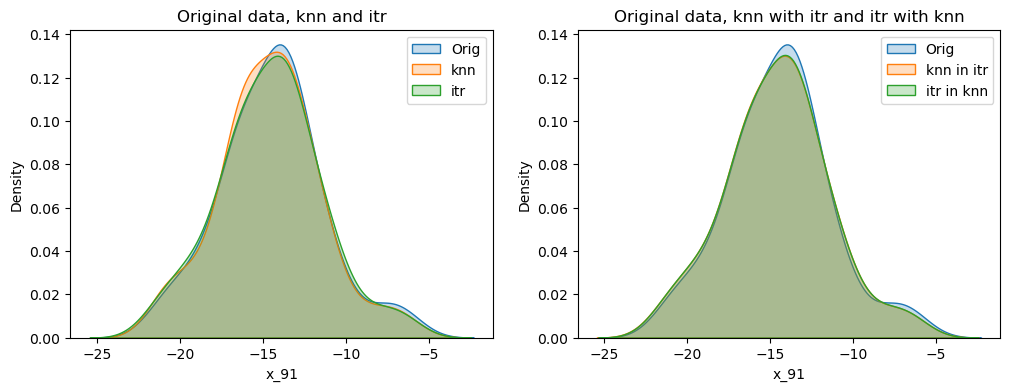

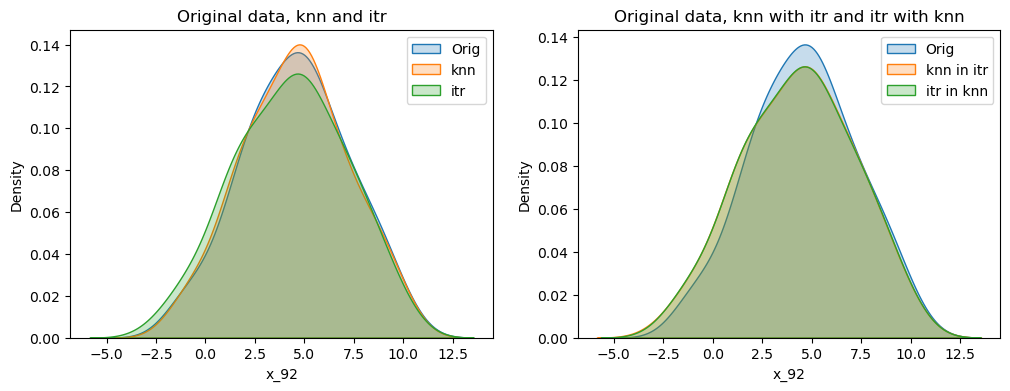

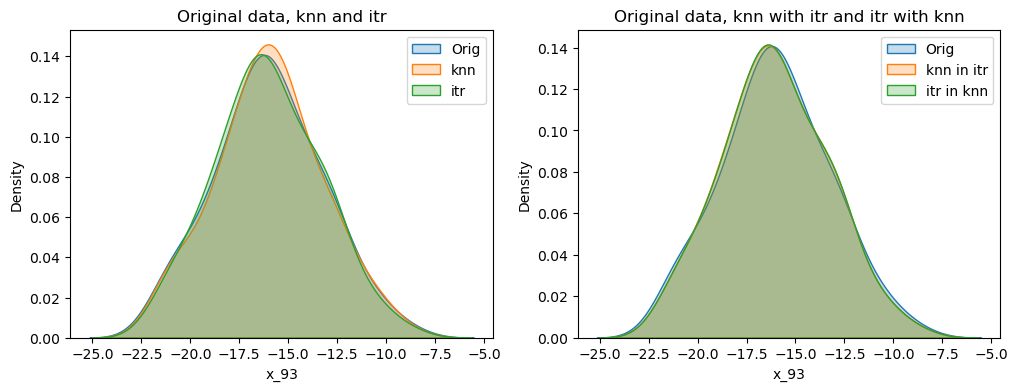

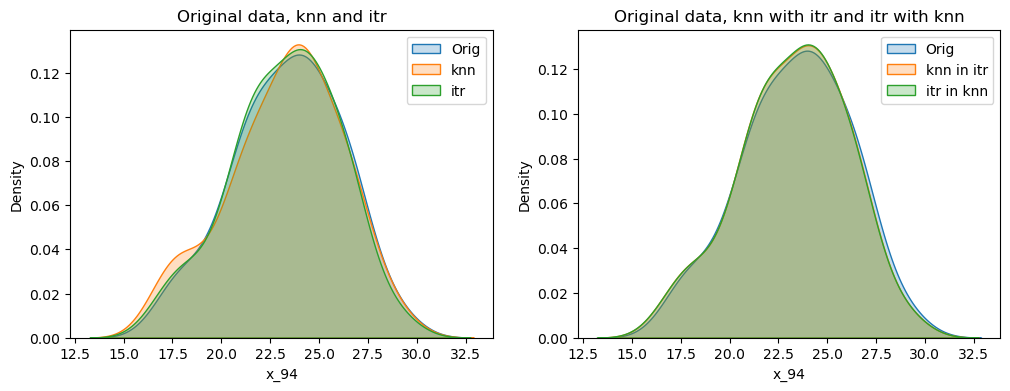

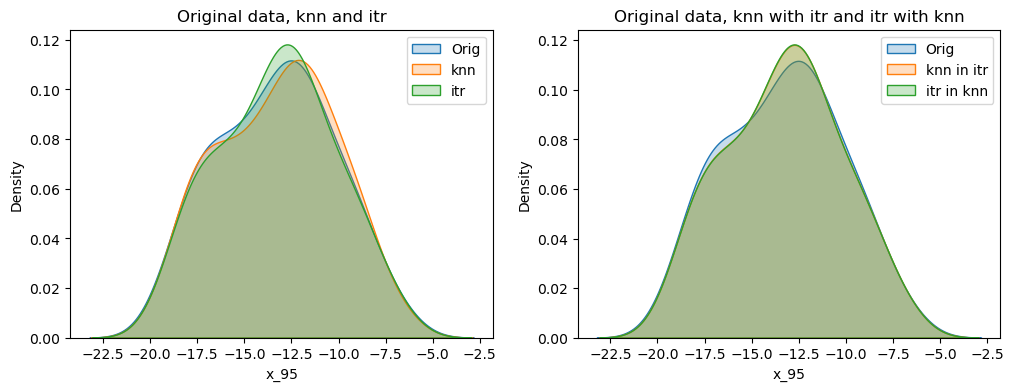

In [136]:
warnings.filterwarnings('ignore')

count_orgi = data_cat['C_ 1'].value_counts(dropna=True)
count_knn = data_knn_imputed.iloc[:, 96:101].sum()
count_itr = data_itr_imputed.iloc[:, 96:101].sum()
count_knn_itr = data_knn_itr_imputed.iloc[:, 96:101].sum()
count_itr_knn = data_itr_knn_imputed.iloc[:, 96:101].sum()

per_orgi = (count_orgi / count_orgi.sum() * 100).sort_index()
per_knn  = (count_knn / count_knn.sum() * 100).sort_index()
per_itr  = (count_itr / count_itr.sum() * 100).sort_index()
per_knn_itr = (count_knn_itr / count_knn_itr.sum() * 100).sort_index()
per_itr_knn = (count_itr_knn / count_itr_knn.sum() * 100).sort_index()

index = np.arange(len(per_orgi))
bar_width = 0.15

plt.figure(figsize=(10, 4))

plt.bar(index, per_orgi, bar_width, color='blue', alpha=0.7, label='orgi')
plt.bar(index + bar_width, per_knn, bar_width, color='orange', alpha=0.7, label='knn')
plt.bar(index + 2*bar_width, per_itr, bar_width, color='red', alpha=0.7, label='itr')
plt.bar(index + 3*bar_width, per_knn_itr, bar_width, color='green', alpha=0.7, label='knn in itr')
plt.bar(index + 4*bar_width, per_itr_knn, bar_width, color='yellow', alpha=0.7, label='itr in knn')

plt.title('Comparison of Percentages')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(index + bar_width / 2, per_orgi.index)
plt.legend()
plt.tight_layout()
plt.show()

print("Sum of percentages for count_orginal:", per_orgi.sum())
print("Sum of percentages for count_uni:", per_orgi.sum())

plt.show()



for col in data.columns[:96]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(data[col], fill=True, label='Orig', ax=ax[0])
    sns.kdeplot(data_knn_imputed[col], fill=True, label='knn', ax=ax[0])
    sns.kdeplot(data_itr_imputed[col], fill=True, label='itr', ax=ax[0])
    ax[0].set_title('Original data, knn and itr')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Density')
    ax[0].legend()

    sns.kdeplot(data[col], fill=True, label='Orig', ax=ax[1])
    sns.kdeplot(data_knn_itr_imputed[col], fill=True, label='knn in itr', ax=ax[1])
    sns.kdeplot(data_itr_knn_imputed[col], fill=True, label='itr in knn', ax=ax[1])
    ax[1].set_title('Original data, knn with itr and itr with knn')
    ax[1].set_xlabel(col)
    ax[1].set_ylabel('Density')
    ax[1].legend()

plt.show()
